In [3]:
!python --version
import sys
sys.executable

Python 2.7.6


'/usr/bin/python2'

In [4]:
from math import sqrt
import os
import glob

from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import lstm2
import numpy as np
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


### This notebook shows how we train a small number of stocks to predict the next 30 day price

# 1. Use stock data only

In [5]:
source_dir='../data/sp500_test'
nlp_dir = None #'../data/nlp_by_company'
revenue_dir = None
# Please make sure these 3 dirs exist 
models_dir = '../models/sp500_test_30/'
supervised_data_dir = '../data/sup_sp500_test_30'
prediction_data_dir = '../data/prediction/sp500_test_30'

rmse_csv = '../data/rsme_ltsm_30.csv'
# look back n days. Note: The hight n_lags is, the more overfitting it becomes 
# because there are more features added with the fix number of data we currently have.
# When we add more features later, we may have to cut down n_lags even more
n_lags = 5 
n_forecast = 30 
n_test = 90 # test = last 90 days from data
'''
config_file = '../config/lstm2.config'
source_dir, models_dir, supervised_data_dir, prediction_data_dir, rmse_csv,n_lags, n_forecast, n_test = lstm2.read_config(config_file)
'''
n_features, orig_dfs, datasets = lstm2.set_up_data(source_dir, 
                                                   nlp_dir, 
                                                   revenue_dir,
                                                   supervised_data_dir, 
                                                   n_lags, 
                                                   n_forecast)
n_features

COL
../data/sp500_test/COL.csv has 4127 rows
            Volume  Adj Close
Date                         
2001-06-15    4200  18.632792
2001-06-18   10900  19.471264
2001-06-19   24600  20.620283
2001-06-20   56000  20.868715
2001-06-21   36700  19.719694
(4093, 12)
('Generating', '../data/sup_sp500_test_30/COL_supervised.csv')
CRM
../data/sp500_test/CRM.csv has 3371 rows
              Volume  Adj Close
Date                           
2004-06-23  43574400       4.30
2004-06-24   8887200       4.19
2004-06-25   6710000       3.95
2004-06-28   2270800       4.00
2004-06-29   2112000       4.10
(3337, 12)
('Generating', '../data/sup_sp500_test_30/CRM_supervised.csv')
DGX
../data/sp500_test/DGX.csv has 4493 rows
             Volume  Adj Close
Date                          
2000-01-03   394800   6.304235
2000-01-04   924400   6.291100
2000-01-05   624000   6.238568
2000-01-06   450400   6.264835
2000-01-07  1608400   6.514379
(4459, 12)
('Generating', '../data/sup_sp500_test_30/DGX_supervise

2

Data for COL


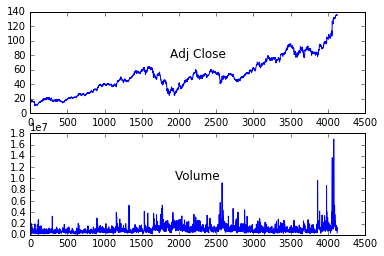

Data for CRM


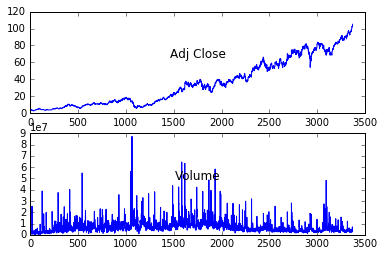

Data for DGX


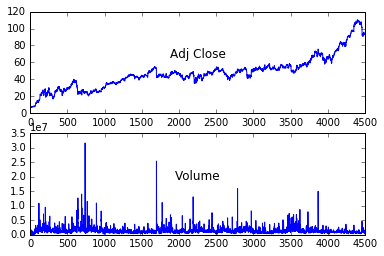

Data for FOX


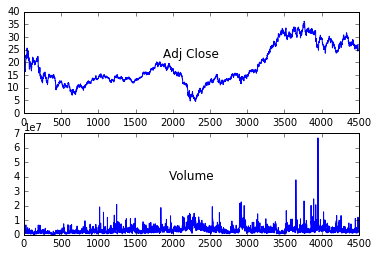

Data for FOXA


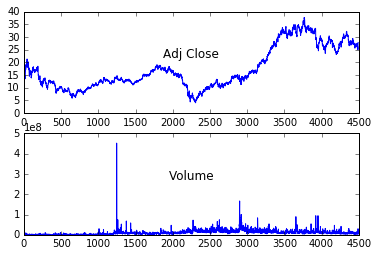

Data for FTI


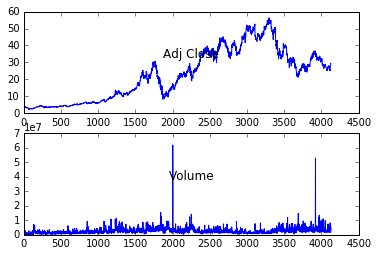

Data for JWN


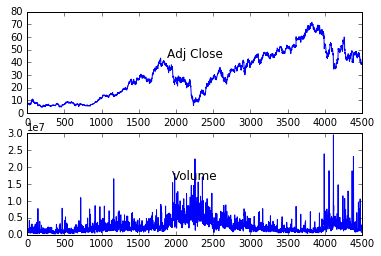

Data for KORS


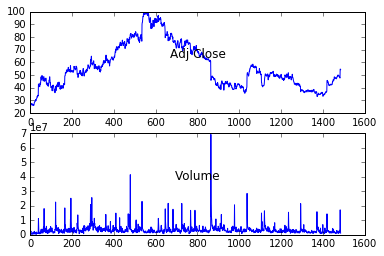

Data for LUV


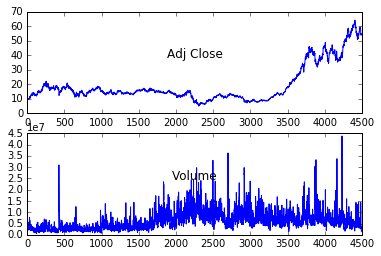

Data for M


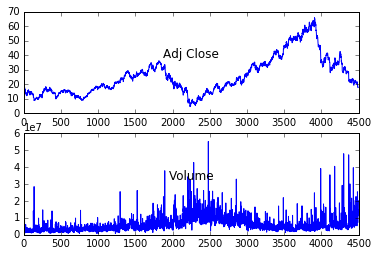

Data for MA


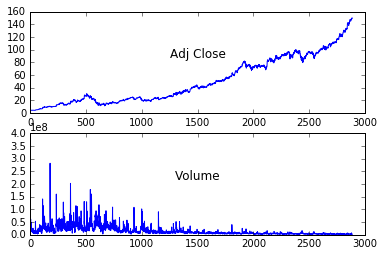

Data for MAA


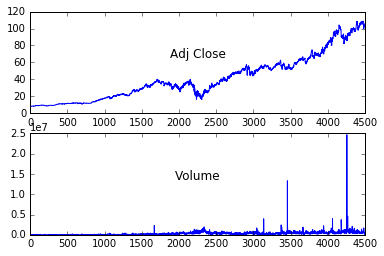

Data for MAC


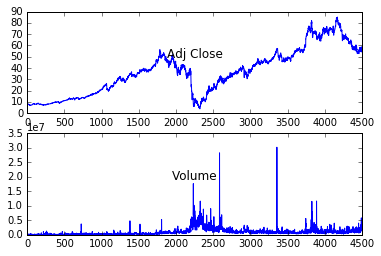

Data for MAR


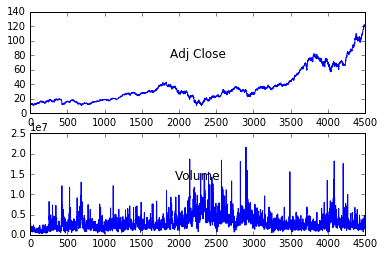

Data for MAS


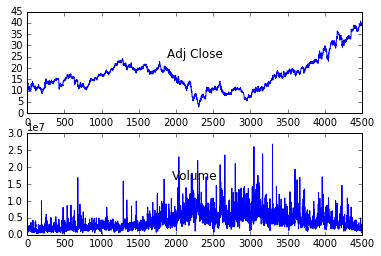

Data for MAT


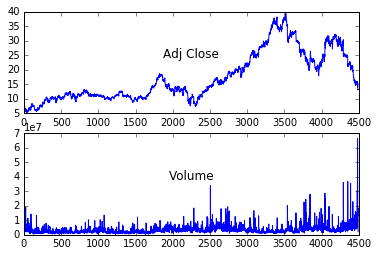

Data for MCD


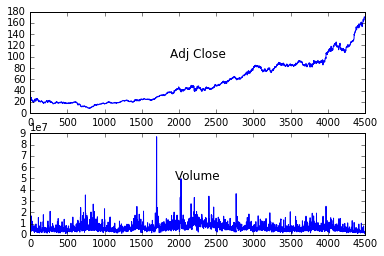

Data for MCHP


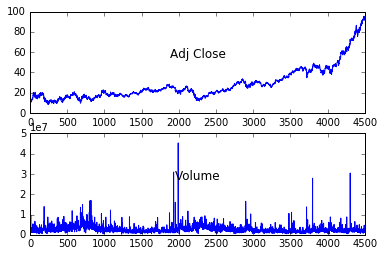

Data for MCK


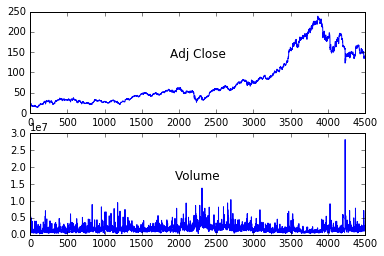

Data for MCO


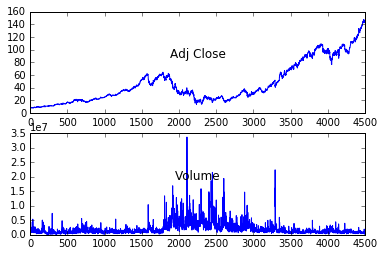

Data for MSFT


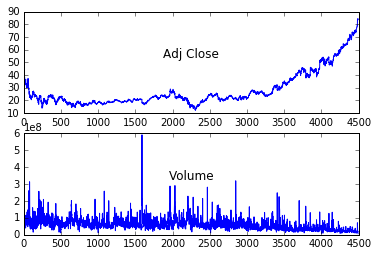

Data for NDAQ


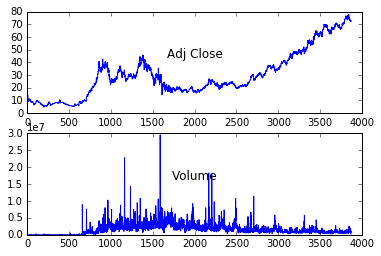

Data for NFLX


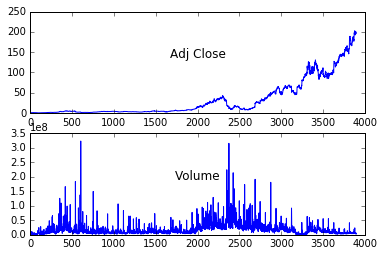

Data for NKE


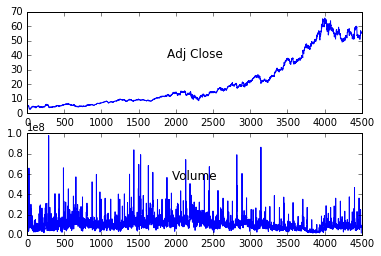

Data for ORCL


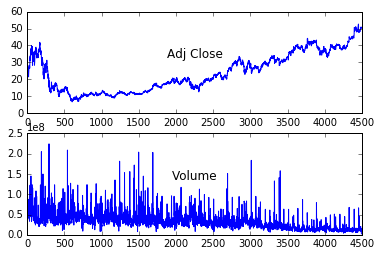

In [6]:
def view_dataframe(df):
    dataset = df
    values = dataset.values
    # Revised order of columns
    groups = np.array(range(len(list(dataset))-1, -1, -1)) #[0, 1, 2, 3, 5] #, 6, 7
    #groups = np.array(range(len(list(dataset)))) #[0, 1, 2, 3, 5] #, 6, 7
    # specify columns to plot
    i = 1
    # plot each column
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group]) #,ax=ax)
        pyplot.title(dataset.columns[group], y=0.5) #, loc='left')
        i += 1
    pyplot.show()

for stock in sorted(orig_dfs.keys()):
    pyplot.figure(figsize=(6,4))
    print('Data for ' + stock)
    view_dataframe(orig_dfs[stock])

#view_dataframe(orig_dfs['MSFT'])

# Multiple lag timesteps

In [6]:
histories = lstm2.build_models(supervised_data_dir, models_dir, n_test, n_lags, n_features, 100)

('Processing', 'CRM')
Train on 3247 samples, validate on 90 samples
Epoch 1/30
3247/3247 [==============================] - 8s - loss: 0.0343 - val_loss: 0.0293
Epoch 2/30
3247/3247 [==============================] - 8s - loss: 0.0302 - val_loss: 0.0196
Epoch 3/30
3247/3247 [==============================] - 8s - loss: 0.0296 - val_loss: 0.0510
Epoch 4/30
3247/3247 [==============================] - 8s - loss: 0.0291 - val_loss: 0.0227
Epoch 5/30
3247/3247 [==============================] - 8s - loss: 0.0287 - val_loss: 0.0230
Evaluating test data...
32/90 [=========>....................] - ETA: 0s['loss']
0.0229787539277
('Saving model to', '../models/sp500_test_30/CRM.h5')
('Processing', 'MSFT')
Train on 4369 samples, validate on 90 samples
Epoch 1/30
4369/4369 [==============================] - 11s - loss: 0.0287 - val_loss: 0.0629
Epoch 2/30
4369/4369 [==============================] - 11s - loss: 0.0268 - val_loss: 0.0338
Epoch 3/30
4369/4369 [==============================] - 11s

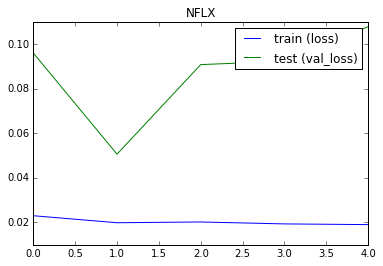

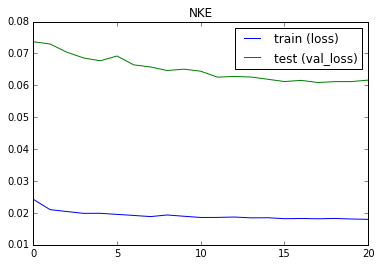

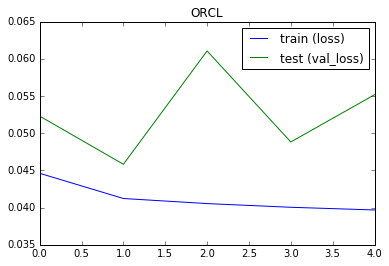

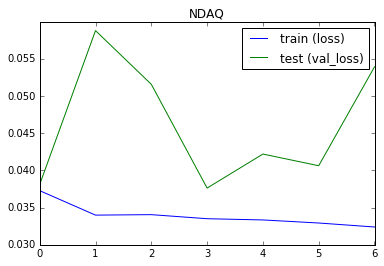

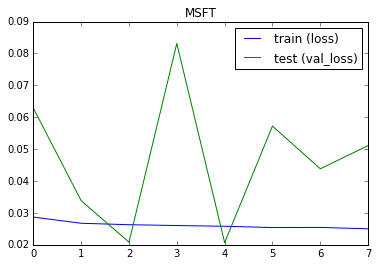

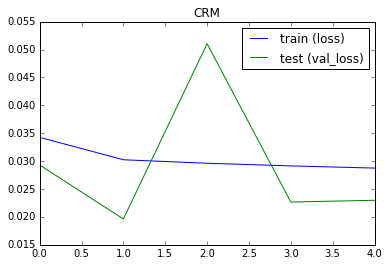

In [7]:
#print(histories)
for stock in histories.keys(): # plot history
    history = histories[stock]
    plt.plot(history.history['loss'], label='train (loss)')
    plt.plot(history.history['val_loss'], label='test (val_loss)')
    plt.title(stock)
    plt.legend()
    plt.show()

In [8]:
predicted_dfs, rmse_df = lstm2.predict_evaluate(models_dir, 
                                                supervised_data_dir, 
                                                prediction_data_dir, 
                                                rmse_csv, 
                                                n_test, n_lags, n_features, n_forecast)

../models/sp500_test_30/*.h5
('loading', '../models/sp500_test_30/CRM.h5')
('Reading', '../data/sup_sp500_test_30/CRM_supervised.csv')
Predicting...
Test RMSE: 2.999
('Writing to', '../data/prediction/sp500_test_30/CRM_predicted.csv')
('loading', '../models/sp500_test_30/MSFT.h5')
('Reading', '../data/sup_sp500_test_30/MSFT_supervised.csv')
Predicting...
Test RMSE: 4.388
('Writing to', '../data/prediction/sp500_test_30/MSFT_predicted.csv')
('loading', '../models/sp500_test_30/NDAQ.h5')
('Reading', '../data/sup_sp500_test_30/NDAQ_supervised.csv')
Predicting...
Test RMSE: 4.391
('Writing to', '../data/prediction/sp500_test_30/NDAQ_predicted.csv')
('loading', '../models/sp500_test_30/NFLX.h5')
('Reading', '../data/sup_sp500_test_30/NFLX_supervised.csv')
Predicting...
Test RMSE: 24.334
('Writing to', '../data/prediction/sp500_test_30/NFLX_predicted.csv')
('loading', '../models/sp500_test_30/NKE.h5')
('Reading', '../data/sup_sp500_test_30/NKE_supervised.csv')
Predicting...
Test RMSE: 4.409


In [15]:
def plot_data(rmse_df, predicted_dfs):
    cnt = 1
    for index, row in sorted(rmse_df.iterrows()):
        key = row['Stock Model']
        if (cnt % 2 != 0):
            fig, axes = plt.subplots(nrows=1, ncols=2)
            ax=axes[0]
        else:
            ax=axes[1]
        predicted_dfs[key].plot(title=key + ': n_forecast = ' + str(n_forecast) +
                                ', n_lags = ' + str(n_lags) + ': price vs days', 
                                figsize=(15,4), 
                                ax=ax)
        cnt += 1
    plt.show()

In [10]:
# default is sort by 'Avg predicted gain'
rmse_df

Stock Model       rsme  Day 0 predicted gain  Day 0 actual gain  \
0         CRM   2.999259              0.042385          -0.016191   
1        MSFT   4.388292             -0.010900           0.009204   
4         NKE   4.408690             -0.004439           0.119957   
2        NDAQ   4.390872             -0.023763           0.061155   
5        ORCL   3.408105             -0.018445           0.108223   
3        NFLX  24.334135             -0.043984          -0.060766   

   Avg predicted gain  Avg actual gain  
0            0.052675         0.035469  
1           -0.009233         0.042196  
4           -0.021698         0.002008  
2           -0.028111         0.023595  
5           -0.030113         0.020995  
3           -0.054937         0.073146

In [11]:
#rmse_df#.sort_values(by='Day 0 actual gain', ascending=False)

In [12]:
predicted_dfs2, summary_df = lstm2.read_prediction_files(prediction_data_dir)
# Should be exactly the same as rmse_df above
summary_df

Stock Model       rsme  Day 0 predicted gain  Day 0 actual gain  \
0         CRM   2.999259              0.042385          -0.016191   
1        MSFT   4.388292             -0.010900           0.009204   
4         NKE   4.408690             -0.004439           0.119957   
2        NDAQ   4.390872             -0.023763           0.061155   
5        ORCL   3.408105             -0.018445           0.108223   
3        NFLX  24.334135             -0.043984          -0.060766   
7           Q  10.722983             -0.046775           0.067273   
6           O   4.249186             -0.053695           0.027702   

   Avg predicted gain  Avg actual gain  
0            0.052675         0.035469  
1           -0.009233         0.042196  
4           -0.021698         0.002008  
2           -0.028111         0.023595  
5           -0.030113         0.020995  
3           -0.054937         0.073146  
7           -0.057930         0.050988  
6           -0.061890         0.006778

In [13]:
# Compare 2 dataframes: They should be same
from pandas.util.testing import assert_frame_equal

#assert_frame_equal(rmse_df, summary_df)

for key in predicted_dfs.keys():
    print(key)
    assert_frame_equal(predicted_dfs[key], predicted_dfs2[key])

NFLX
NKE
ORCL
NDAQ
MSFT
CRM


# Visualize Results

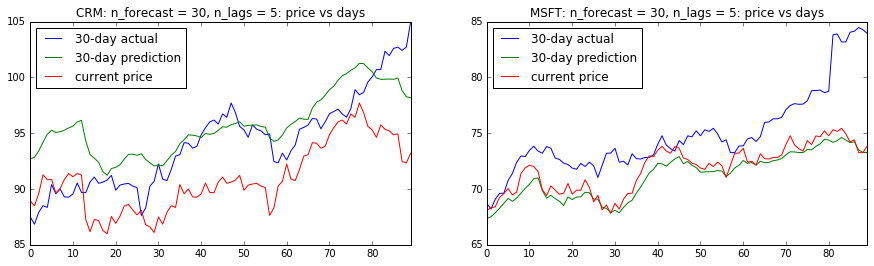

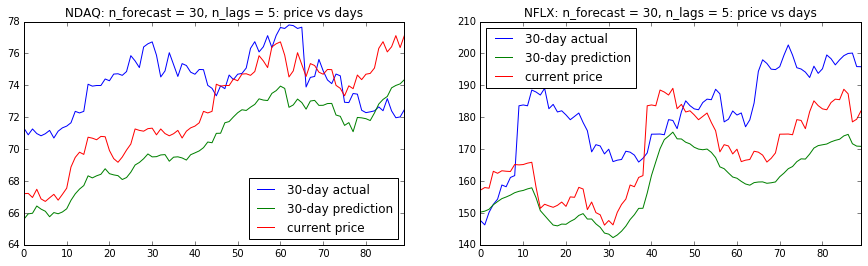

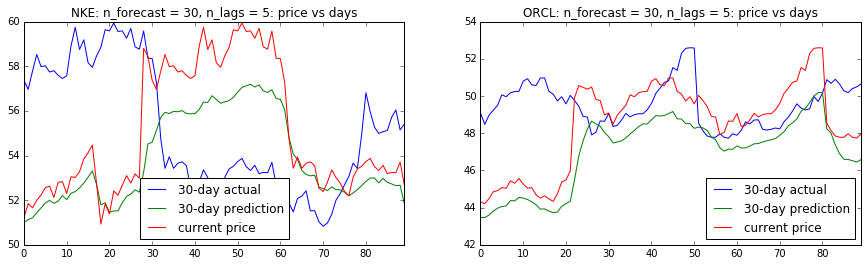

In [14]:
plot_data(rmse_df, predicted_dfs)

# 2. Use stock price, news and revenue data


In [7]:
n_lags = 5
nlp_dir = '../data/nlp_by_company'
revenue_dir = '../metadata/revenue'
n_features, orig_dfs, datasets = lstm2.set_up_data(source_dir, 
                                                   nlp_dir,
                                                   revenue_dir,
                                                   supervised_data_dir, 
                                                   n_lags, 
                                                   n_forecast)

COL
../data/sp500_test/COL.csv has 4127 rows
            Volume  Adj Close
Date                         
2001-06-15    4200  18.632792
2001-06-18   10900  19.471264
2001-06-19   24600  20.620283
2001-06-20   56000  20.868715
2001-06-21   36700  19.719694
('Reading', '../metadata/revenue/COL_Financials_by_Quarter.csv')
            year quarter  basiceps    netincome  totalrevenue
Date                                                         
2017-05-01  2017      Q1      1.11  145000000.0  1.193000e+09
2017-08-01  2017      Q2      1.28  168000000.0  1.342000e+09
2017-11-01  2017      Q3      1.13  179000000.0  2.094000e+09
2018-02-01  2017      Q4      0.00          0.0  0.000000e+00
2018-06-01  2017      FY      0.00          0.0  0.000000e+00
('Process revenue data', 4127, 4127)
('Reading', '../data/nlp_by_company/COL.csv')
[0]
Empty DataFrame
Columns: [buy, sell, positivity, subjectivity, financial_report_quarter]
Index: []
('Process news data', 4127, 4127)
(4093, 60)
('Generating', 

LUV
../data/sp500_test/LUV.csv has 4493 rows
             Volume  Adj Close
Date                          
2000-01-03  3277800   9.970237
2000-01-04  4702000   9.695464
2000-01-05  3432900   9.656210
2000-01-06  2809500   9.616959
2000-01-07  4967100   9.970237
('Reading', '../metadata/revenue/LUV_Financials_by_Quarter.csv')
            year quarter  basiceps    netincome  totalrevenue
Date                                                         
2017-05-01  2017      Q1      0.57  351000000.0  4.883000e+09
2017-08-01  2017      Q2      1.24  746000000.0  5.744000e+09
2017-11-01  2017      Q3      0.84  503000000.0  5.271000e+09
2018-02-01  2017      Q4      0.00          0.0  0.000000e+00
2018-06-01  2017      FY      0.00          0.0  0.000000e+00
('Process revenue data', 4493, 4493)
('Reading', '../data/nlp_by_company/LUV.csv')
[0]
Empty DataFrame
Columns: [buy, sell, positivity, subjectivity, financial_report_quarter]
Index: []
('Process news data', 4493, 4493)
(4459, 60)
('Genera

MCD
../data/sp500_test/MCD.csv has 4493 rows
             Volume  Adj Close
Date                          
2000-01-03  4520600  25.536549
2000-01-04  4216500  25.012924
2000-01-05  5231600  25.415709
2000-01-06  4809400  25.053204
2000-01-07  5124700  25.697659
('Reading', '../metadata/revenue/MCD_Financials_by_Quarter.csv')
            year quarter  basiceps     netincome  totalrevenue
Date                                                          
2017-05-01  2017      Q1      1.48  1.214800e+09  5.675900e+09
2017-08-01  2017      Q2      1.72  1.395100e+09  6.049700e+09
2017-11-01  2017      Q3      2.34  1.883700e+09  5.754600e+09
2018-02-01  2017      Q4      0.00  0.000000e+00  0.000000e+00
2018-06-01  2017      FY      0.00  0.000000e+00  0.000000e+00
('Process revenue data', 4493, 4493)
('Reading', '../data/nlp_by_company/MCD.csv')
[0]
Empty DataFrame
Columns: [buy, sell, positivity, subjectivity, financial_report_quarter]
Index: []
('Process news data', 4493, 4493)
(4459, 60)
(

ORCL
../data/sp500_test/ORCL.csv has 4493 rows
               Volume  Adj Close
Date                            
2000-01-03   98114800  26.690121
2000-01-04  116824800  24.331789
2000-01-05  166054000  23.046711
2000-01-06  109880000  21.691025
2000-01-07   91755600  23.357389
('Reading', '../metadata/revenue/ORCL_Financials_by_Quarter.csv')
            year quarter  basiceps     netincome  totalrevenue
Date                                                          
2017-05-01  2017      Q1      0.44  1.832000e+09  8.595000e+09
2017-08-01  2017      Q2      0.50  2.032000e+09  9.035000e+09
2017-11-01  2017      Q3      0.55  2.239000e+09  9.205000e+09
2018-02-01  2017      Q4      0.78  3.232000e+09  1.089300e+10
2018-06-01  2017      FY      2.27  9.335000e+09  3.772800e+10
('Process revenue data', 4493, 4493)
('Reading', '../data/nlp_by_company/ORCL.csv')
[0]
Empty DataFrame
Columns: [buy, sell, positivity, subjectivity, financial_report_quarter]
Index: []
('Process news data', 4493, 

# Data Analysis

('Number of features:', 10)
Data for COL


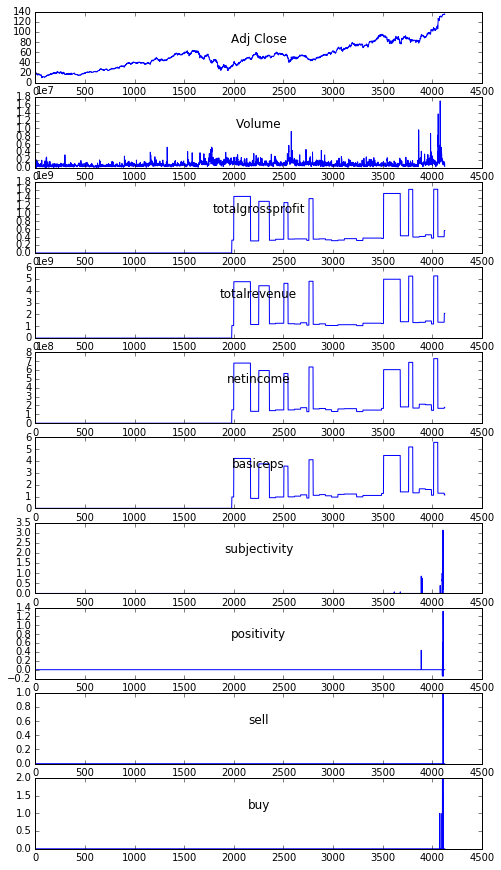

Data for CRM


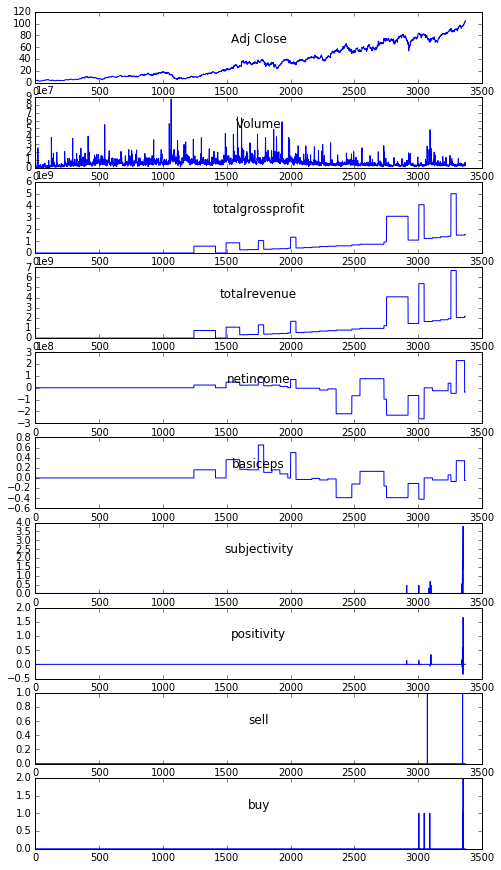

Data for DGX


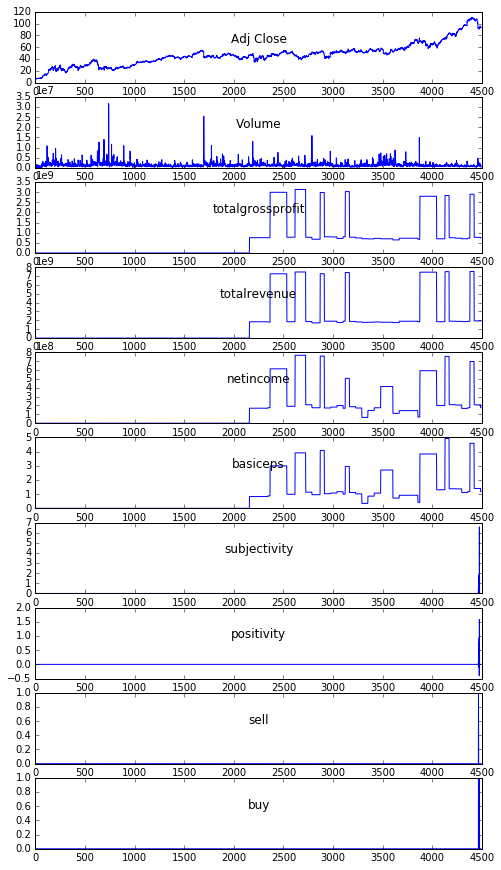

Data for FOX


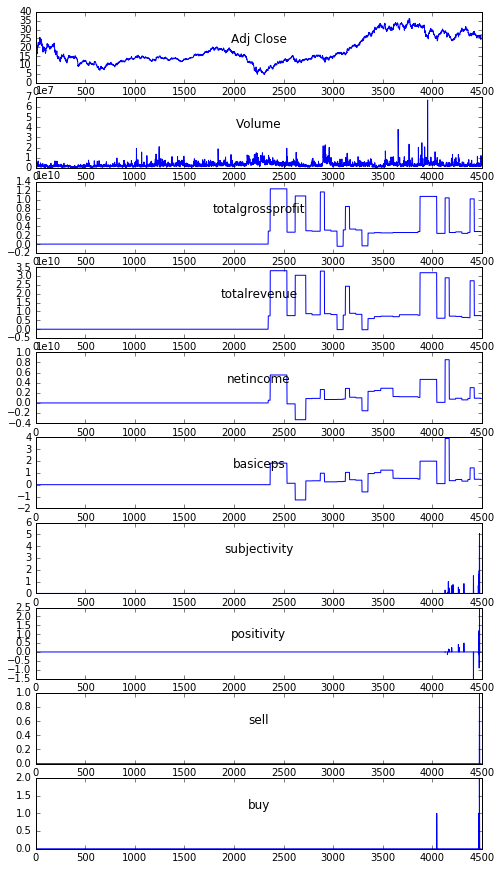

Data for FOXA


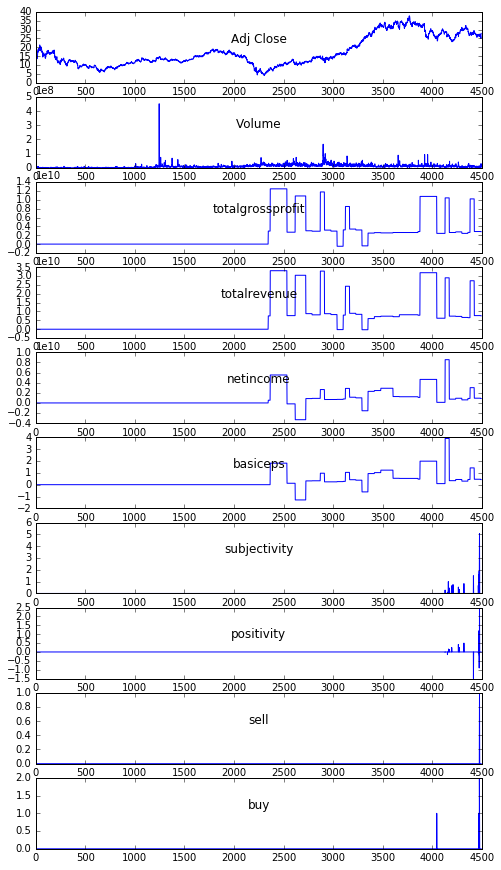

Data for FTI


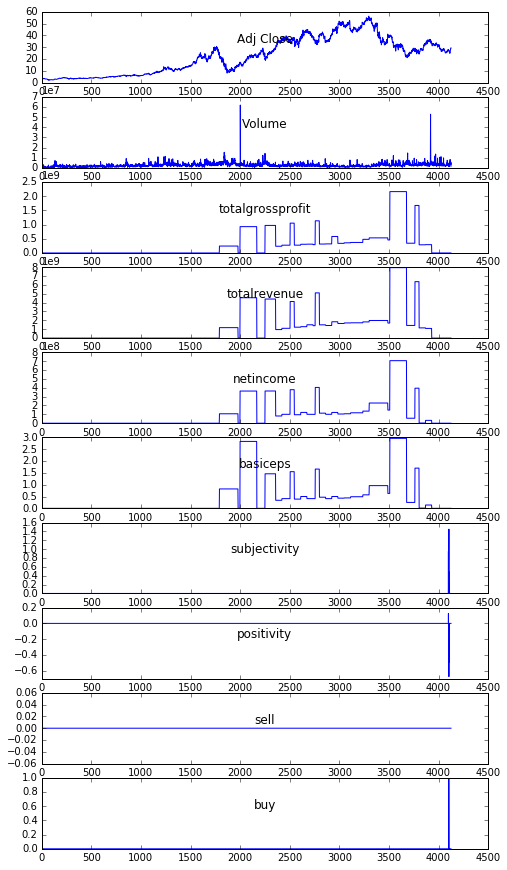

Data for JWN


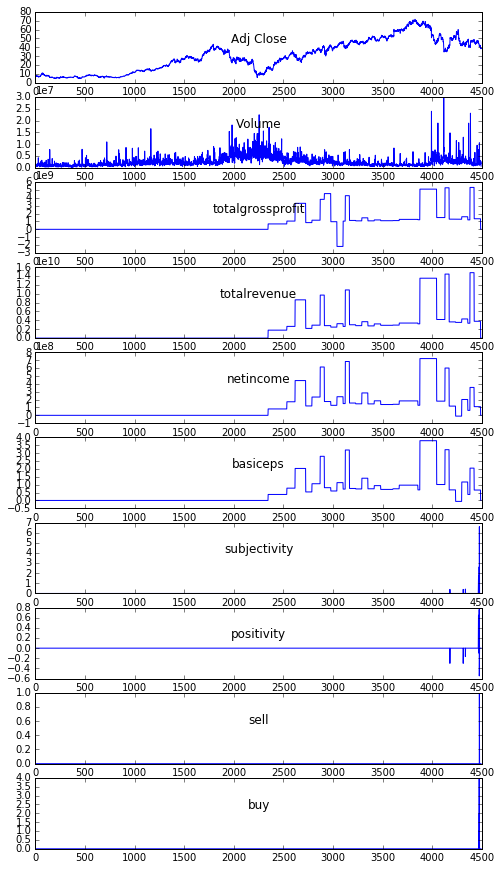

Data for KORS


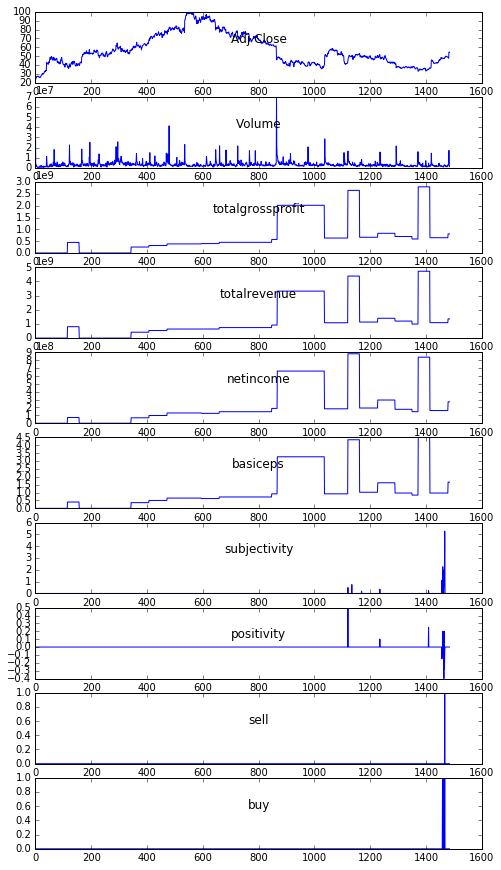

Data for LUV


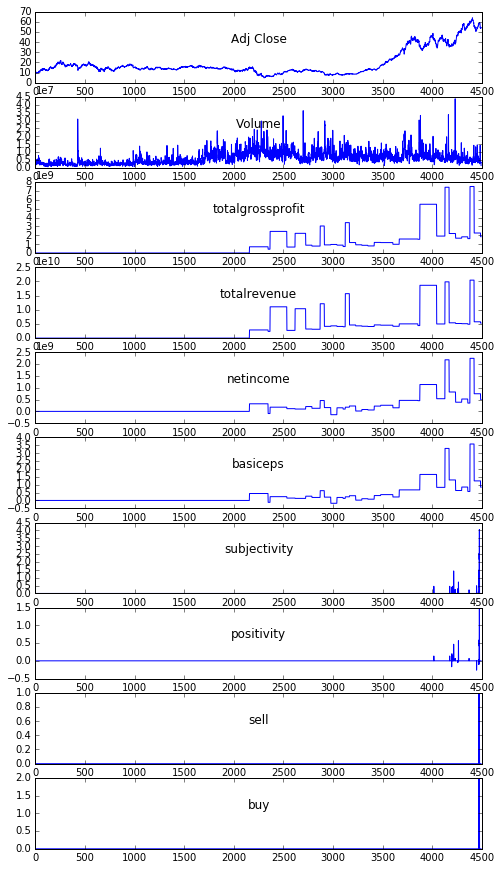

Data for M


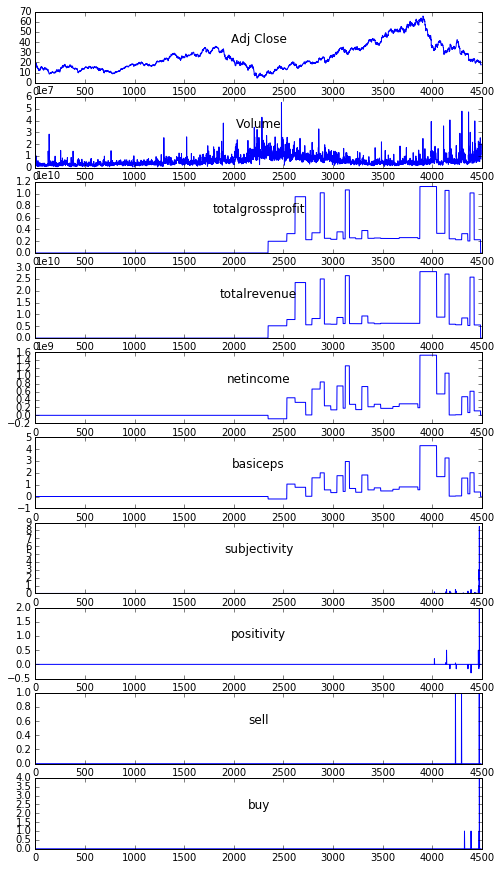

Data for MA


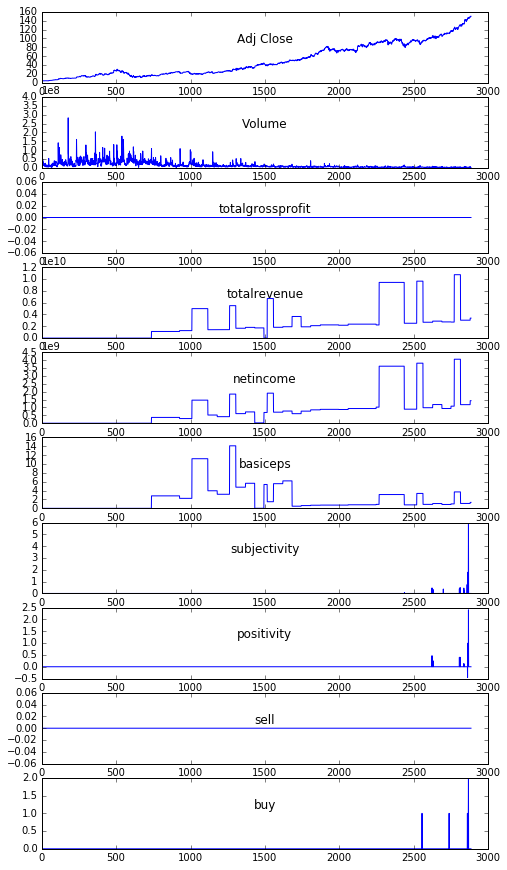

Data for MAA


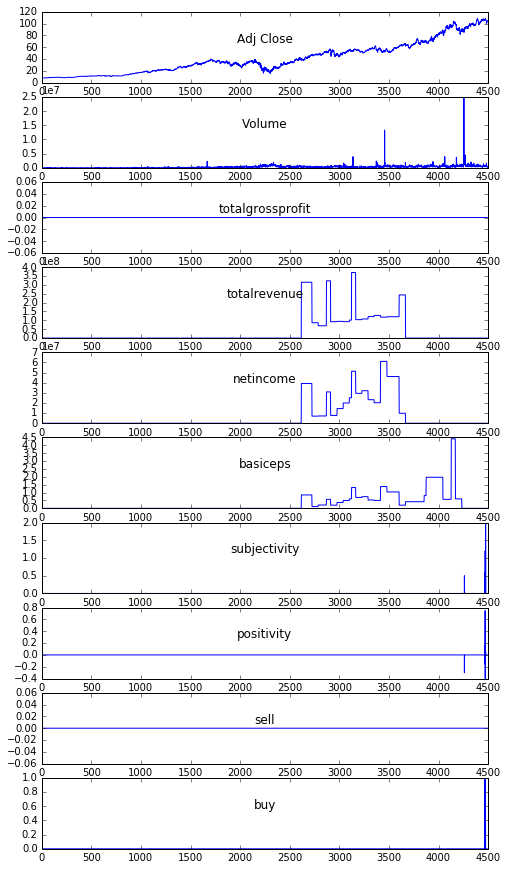

Data for MAC


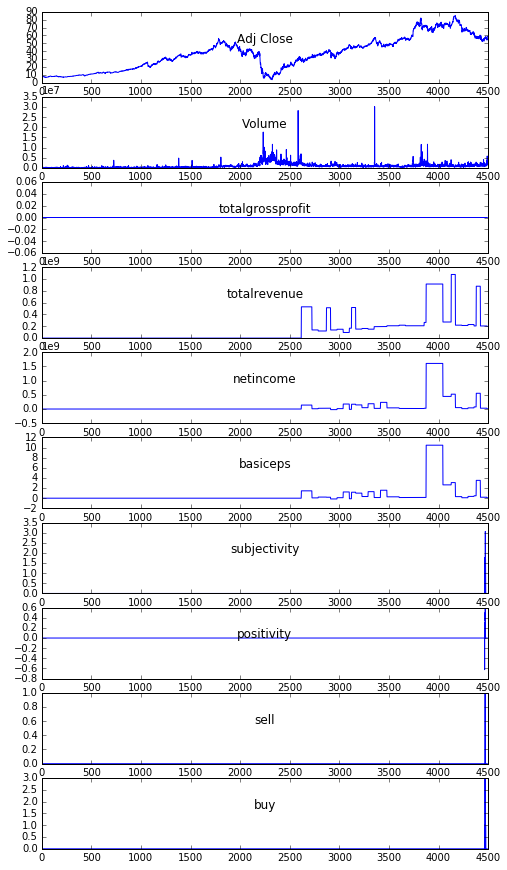

Data for MAR


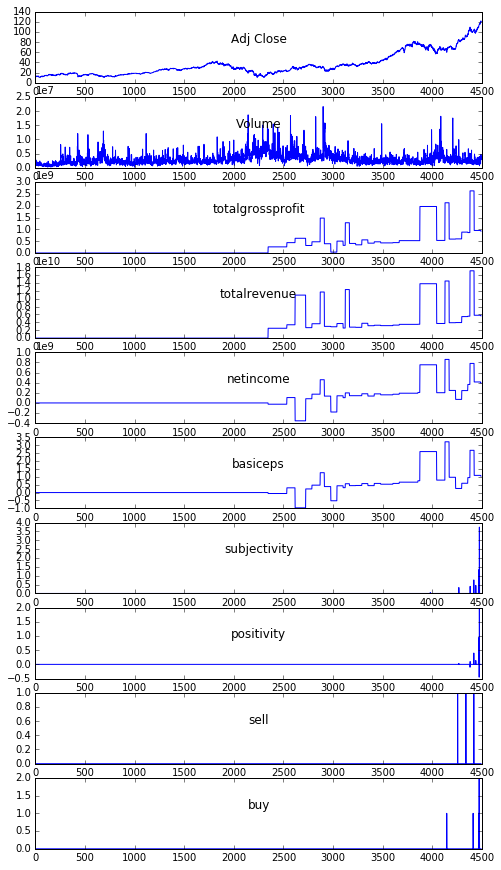

Data for MAS


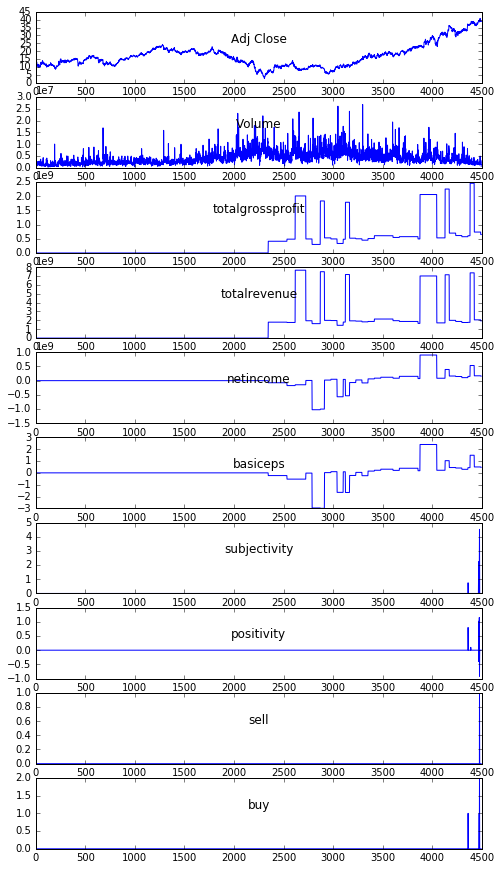

Data for MAT


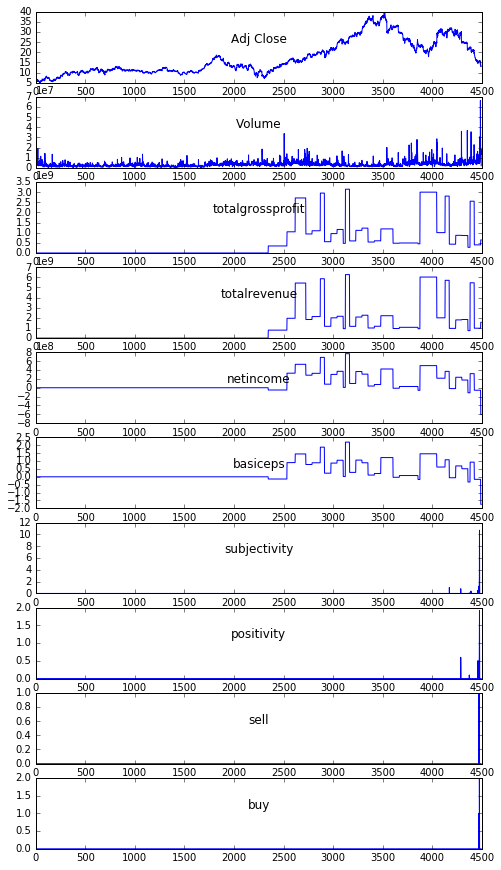

Data for MCD


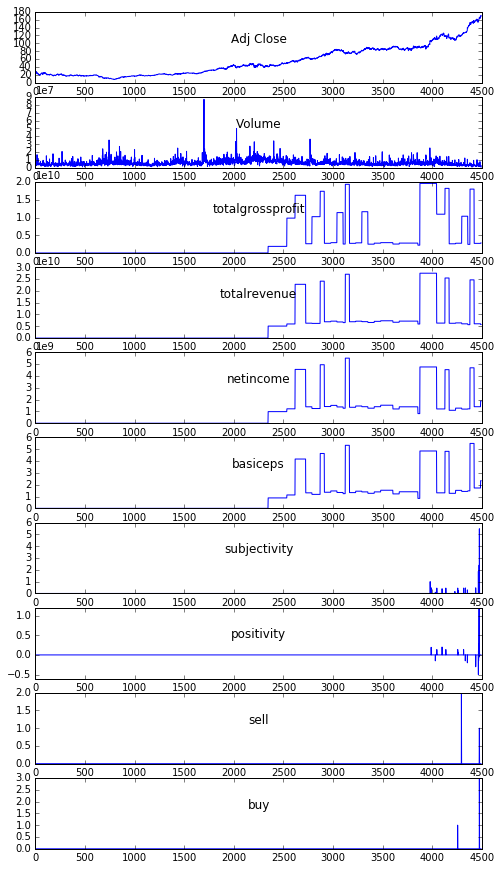

Data for MCHP


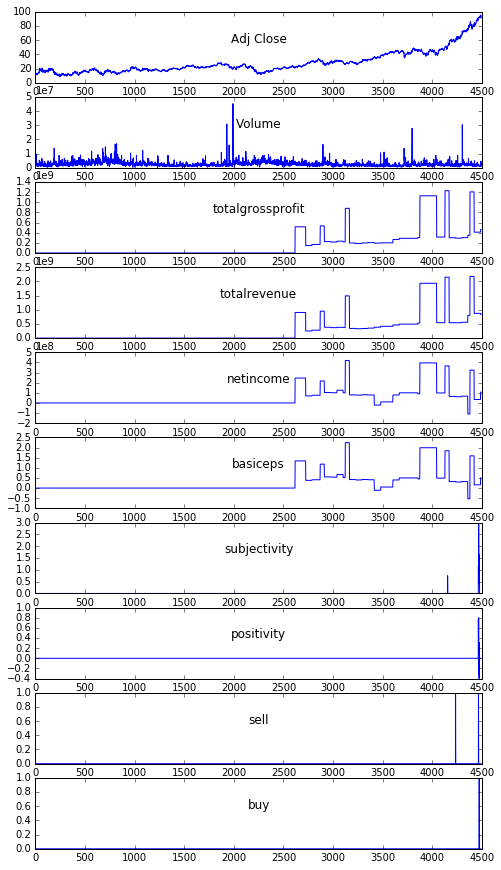

Data for MCK


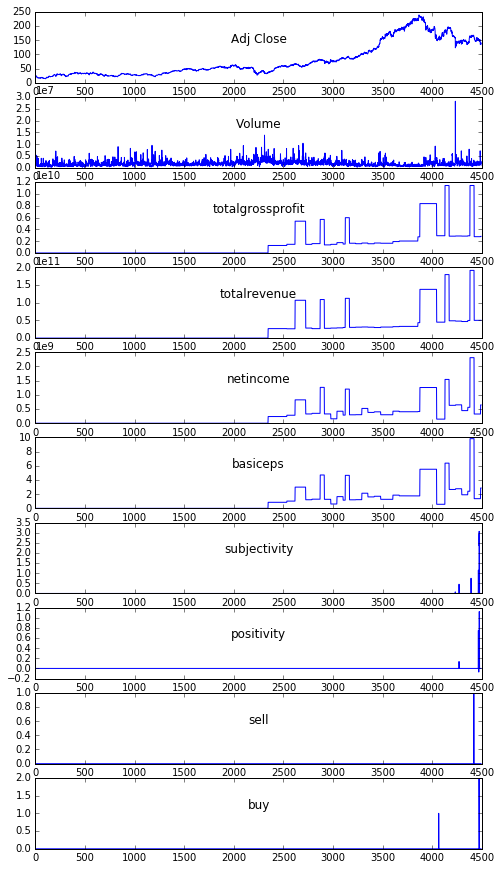

Data for MCO


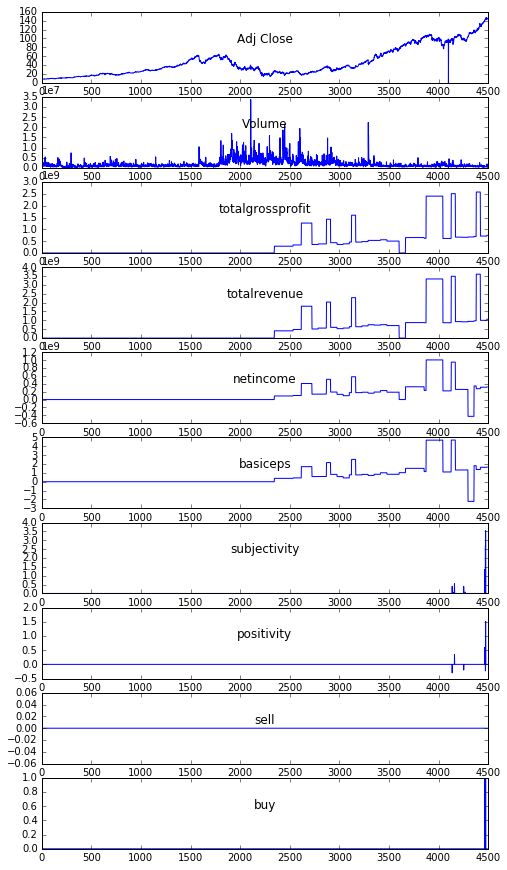

Data for MSFT


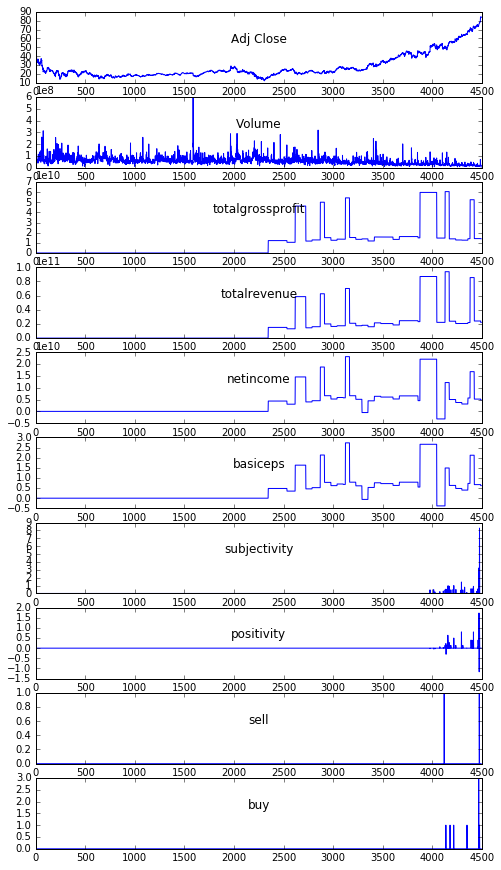

Data for NDAQ


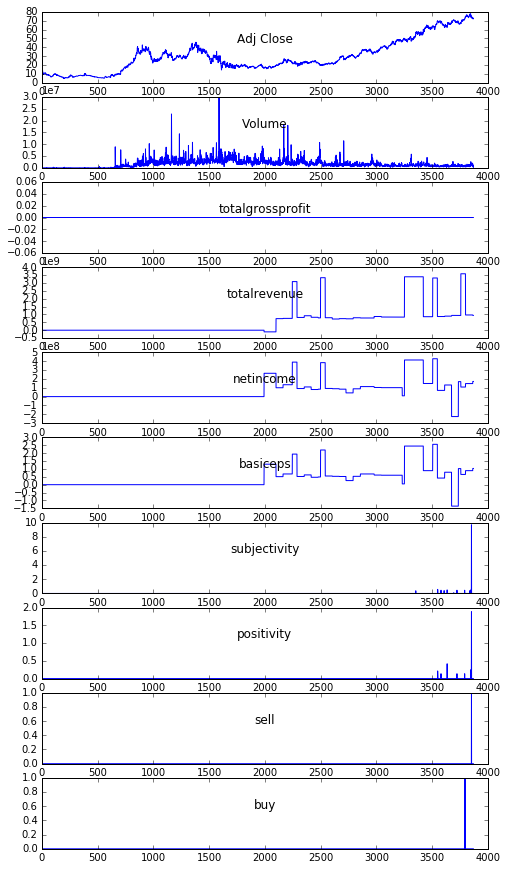

Data for NFLX


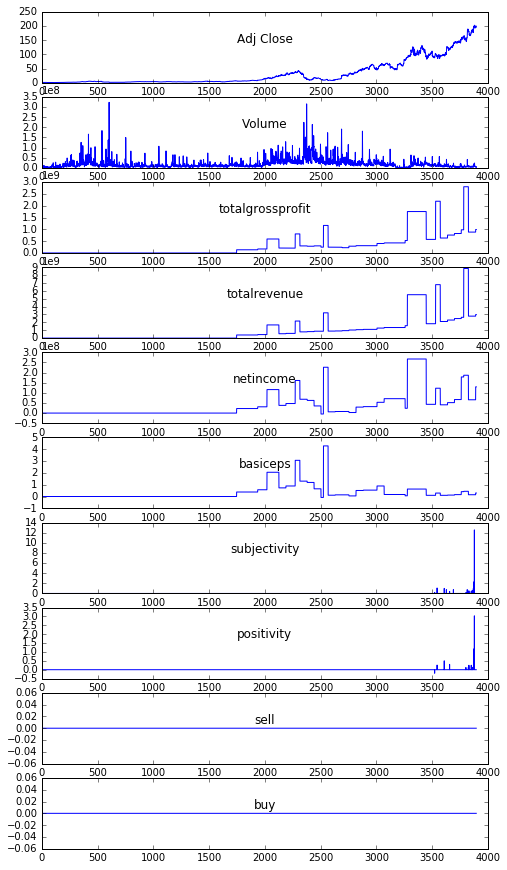

Data for NKE


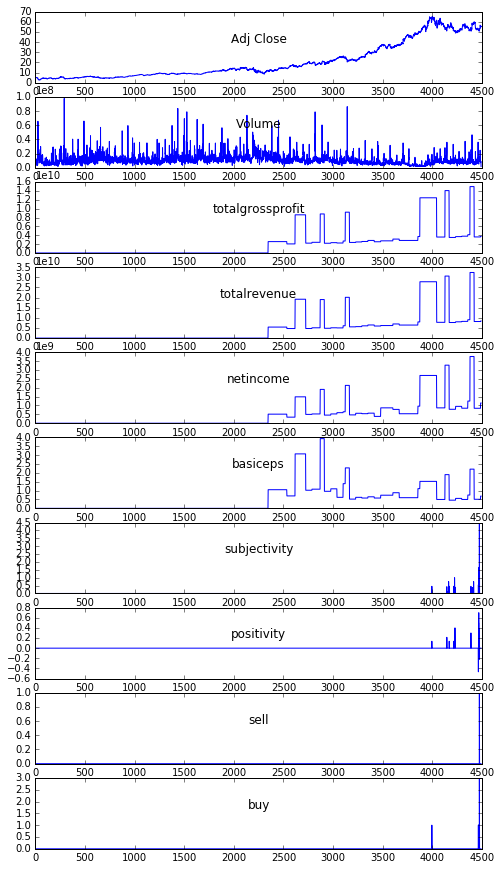

Data for ORCL


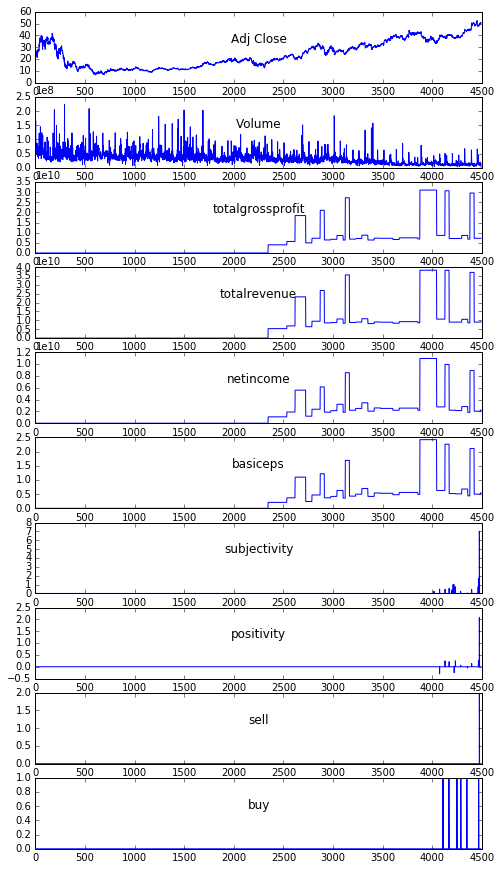

In [8]:
print('Number of features:', n_features)
for stock in sorted(orig_dfs.keys()):
    pyplot.figure(figsize=(8,15))
#    print(orig_dfs[stock][['decline']].max())
    #print(orig_dfs[stock].positivity.unique())
    #print(orig_dfs[stock].subjectivity.unique())
    #.groupby().agg({'decline': ['min', 'max', 'unique'], 'sell': ['first', 'max', 'unique']})
    print('Data for ' + stock)
    view_dataframe(orig_dfs[stock])


Data for MSFT


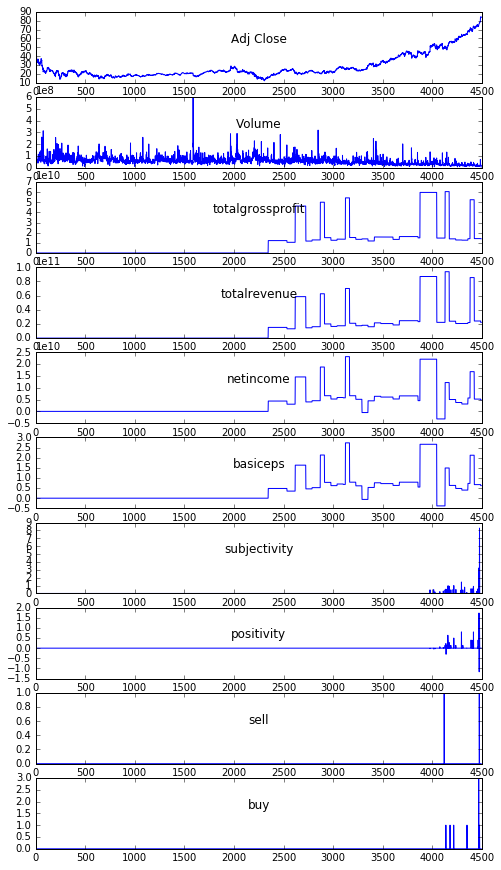

In [9]:
# Just look at 1 stock for simplicity
stock = 'MSFT'
print('Data for ' + stock)
pyplot.figure(figsize=(8,15))
view_dataframe(orig_dfs[stock])

* Stock data starts from 2000-01
* News data (subjectivity, positivity, decline, sell, buy, scandal) 
    + only available approximately for the past 500 days (ex: MSFT)
    + very sparsed
    + scandal, decline are consistently zero. Should we drop them?
    + buy, sell are sparsed, mostly 0s. Should we drop them?
* Revenue data () start from 2010?
    + operatingrevenue are 0s so we decided to drop them

## Create Models

('Processing', 'CRM')
Train on 3247 samples, validate on 90 samples
Epoch 1/30
3247/3247 [==============================] - 17s - loss: 0.0382 - val_loss: 0.0433
Epoch 2/30
3247/3247 [==============================] - 16s - loss: 0.0309 - val_loss: 0.0239
Epoch 3/30
3247/3247 [==============================] - 16s - loss: 0.0300 - val_loss: 0.0262
Epoch 4/30
3247/3247 [==============================] - 16s - loss: 0.0300 - val_loss: 0.0245
Epoch 5/30
3247/3247 [==============================] - 16s - loss: 0.0283 - val_loss: 0.0678
Evaluating test data...
32/90 [=========>....................] - ETA: 0s['loss']
0.0677750883003
('Saving model to', '../models/sp500_test_30/CRM.h5')
('Processing', 'MSFT')
Train on 4369 samples, validate on 90 samples
Epoch 1/30
4369/4369 [==============================] - 23s - loss: 0.0316 - val_loss: 0.0478
Epoch 2/30
4369/4369 [==============================] - 22s - loss: 0.0271 - val_loss: 0.1095
Epoch 3/30
4369/4369 [==============================] 

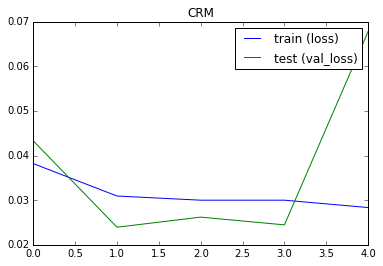

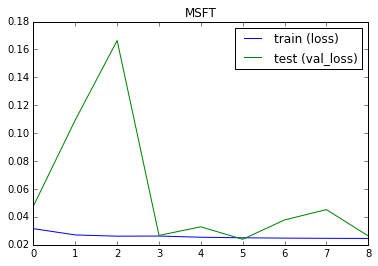

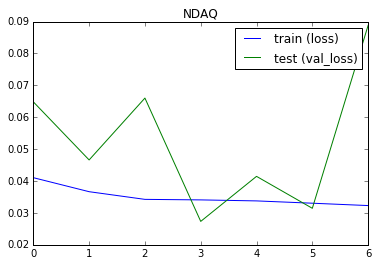

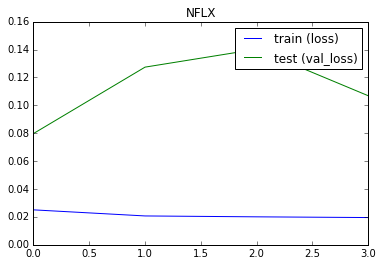

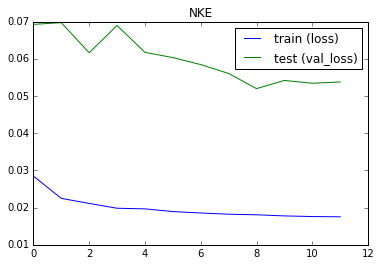

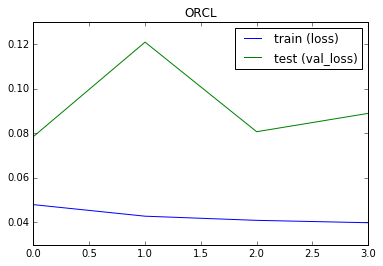

In [18]:
# With more features, increase n_neurons
histories = lstm2.build_models(supervised_data_dir, models_dir, n_test, n_lags, n_features, 
                               200)
#print(histories)
for stock in sorted(histories.keys()): # plot history
    history = histories[stock]
    plt.plot(history.history['loss'], label='train (loss)')
    plt.plot(history.history['val_loss'], label='test (val_loss)')
    plt.title(stock)
    plt.legend()
    plt.show()

## Make Predictions

In [19]:
predicted_dfs2, rmse_df2 = lstm2.predict_evaluate(models_dir, 
                                                supervised_data_dir, 
                                                prediction_data_dir, 
                                                rmse_csv, 
                                                n_test, n_lags, n_features, n_forecast)

../models/sp500_test_30/*.h5
('loading', '../models/sp500_test_30/CRM.h5')
('Reading', '../data/sup_sp500_test_30/CRM_supervised.csv')
Predicting...
Test RMSE: 7.720
('Writing to', '../data/prediction/sp500_test_30/CRM_predicted.csv')
('loading', '../models/sp500_test_30/MSFT.h5')
('Reading', '../data/sup_sp500_test_30/MSFT_supervised.csv')
Predicting...
Test RMSE: 2.705
('Writing to', '../data/prediction/sp500_test_30/MSFT_predicted.csv')
('loading', '../models/sp500_test_30/NDAQ.h5')
('Reading', '../data/sup_sp500_test_30/NDAQ_supervised.csv')
Predicting...
Test RMSE: 6.759
('Writing to', '../data/prediction/sp500_test_30/NDAQ_predicted.csv')
('loading', '../models/sp500_test_30/NFLX.h5')
('Reading', '../data/sup_sp500_test_30/NFLX_supervised.csv')
Predicting...
Test RMSE: 26.017
('Writing to', '../data/prediction/sp500_test_30/NFLX_predicted.csv')
('loading', '../models/sp500_test_30/NKE.h5')
('Reading', '../data/sup_sp500_test_30/NKE_supervised.csv')
Predicting...
Test RMSE: 3.749


In [20]:
# check RMSE as risk indicators
rmse_df2

Stock Model       rsme  Day 0 predicted gain  Day 0 actual gain  \
1        MSFT   2.705045              0.042944           0.009204   
4         NKE   3.748688              0.018007           0.119957   
0         CRM   7.719930             -0.047762          -0.016191   
3        NFLX  26.017039             -0.034099          -0.060766   
5        ORCL   5.160057             -0.012156           0.108223   
2        NDAQ   6.758840             -0.066351           0.061155   

   Avg predicted gain  Avg actual gain  
1            0.025673         0.042196  
4            0.008923         0.002008  
0           -0.041016         0.035469  
3           -0.052429         0.073146  
5           -0.059650         0.020995  
2           -0.065851         0.023595

In [21]:
# Compare to the previous one
rmse_df

Stock Model       rsme  Day 0 predicted gain  Day 0 actual gain  \
0         CRM   2.999259              0.042385          -0.016191   
1        MSFT   4.388292             -0.010900           0.009204   
4         NKE   4.408690             -0.004439           0.119957   
2        NDAQ   4.390872             -0.023763           0.061155   
5        ORCL   3.408105             -0.018445           0.108223   
3        NFLX  24.334135             -0.043984          -0.060766   

   Avg predicted gain  Avg actual gain  
0            0.052675         0.035469  
1           -0.009233         0.042196  
4           -0.021698         0.002008  
2           -0.028111         0.023595  
5           -0.030113         0.020995  
3           -0.054937         0.073146

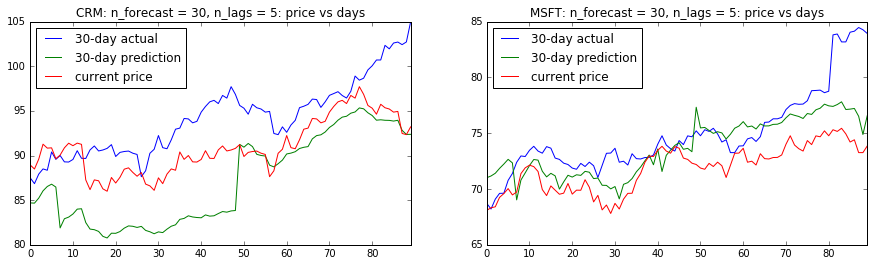

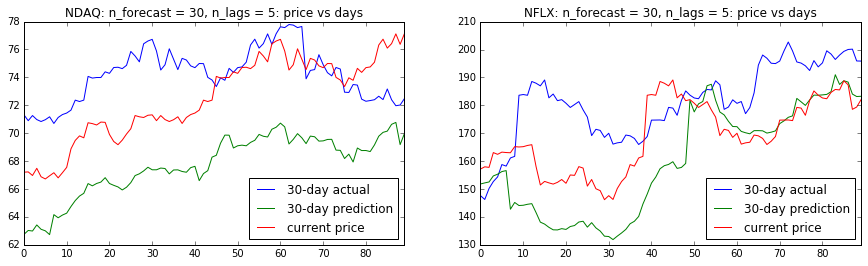

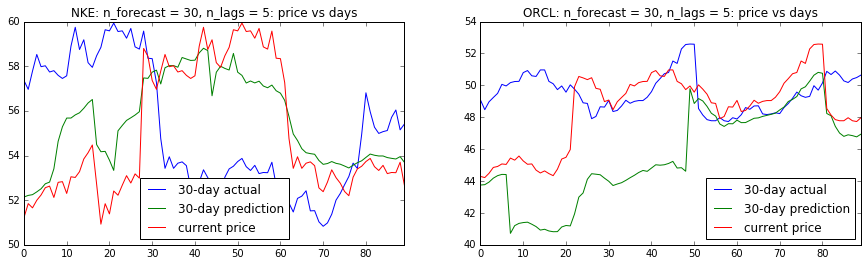

In [22]:
plot_data(rmse_df2, predicted_dfs2)

# Observations:

* This 2nd set of predictions with news and revenue data looks better than the first set

# Tuning number of neurons

Let's try to decrease n_neurons to see overfitting improves

In [11]:
#n_lags = 3 # look back 3 days

'''
Try with 50 stocks
'''
source_dir='../data/sp500_test' #'../data/sp500_1' #
print(n_lags)
n_features, orig_dfs, datasets = lstm2.set_up_data(source_dir, 
                                                   nlp_dir, 
                                                   revenue_dir,
                                                   supervised_data_dir, 
                                                   n_lags, 
                                                   n_forecast)
n_features

5
COL
../data/sp500_test/COL.csv has 4127 rows
            Volume  Adj Close
Date                         
2001-06-15    4200  18.632792
2001-06-18   10900  19.471264
2001-06-19   24600  20.620283
2001-06-20   56000  20.868715
2001-06-21   36700  19.719694
('Reading', '../metadata/revenue/COL_Financials_by_Quarter.csv')
            year quarter  basiceps    netincome  totalrevenue
Date                                                         
2017-05-01  2017      Q1      1.11  145000000.0  1.193000e+09
2017-08-01  2017      Q2      1.28  168000000.0  1.342000e+09
2017-11-01  2017      Q3      1.13  179000000.0  2.094000e+09
2018-02-01  2017      Q4      0.00          0.0  0.000000e+00
2018-06-01  2017      FY      0.00          0.0  0.000000e+00
('Process revenue data', 4127, 4127)
('Reading', '../data/nlp_by_company/COL.csv')
[0]
Empty DataFrame
Columns: [buy, sell, positivity, subjectivity, financial_report_quarter]
Index: []
('Process news data', 4127, 4127)
(4093, 60)
('Generating'

LUV
../data/sp500_test/LUV.csv has 4493 rows
             Volume  Adj Close
Date                          
2000-01-03  3277800   9.970237
2000-01-04  4702000   9.695464
2000-01-05  3432900   9.656210
2000-01-06  2809500   9.616959
2000-01-07  4967100   9.970237
('Reading', '../metadata/revenue/LUV_Financials_by_Quarter.csv')
            year quarter  basiceps    netincome  totalrevenue
Date                                                         
2017-05-01  2017      Q1      0.57  351000000.0  4.883000e+09
2017-08-01  2017      Q2      1.24  746000000.0  5.744000e+09
2017-11-01  2017      Q3      0.84  503000000.0  5.271000e+09
2018-02-01  2017      Q4      0.00          0.0  0.000000e+00
2018-06-01  2017      FY      0.00          0.0  0.000000e+00
('Process revenue data', 4493, 4493)
('Reading', '../data/nlp_by_company/LUV.csv')
[0]
Empty DataFrame
Columns: [buy, sell, positivity, subjectivity, financial_report_quarter]
Index: []
('Process news data', 4493, 4493)
(4459, 60)
('Genera

MCD
../data/sp500_test/MCD.csv has 4493 rows
             Volume  Adj Close
Date                          
2000-01-03  4520600  25.536549
2000-01-04  4216500  25.012924
2000-01-05  5231600  25.415709
2000-01-06  4809400  25.053204
2000-01-07  5124700  25.697659
('Reading', '../metadata/revenue/MCD_Financials_by_Quarter.csv')
            year quarter  basiceps     netincome  totalrevenue
Date                                                          
2017-05-01  2017      Q1      1.48  1.214800e+09  5.675900e+09
2017-08-01  2017      Q2      1.72  1.395100e+09  6.049700e+09
2017-11-01  2017      Q3      2.34  1.883700e+09  5.754600e+09
2018-02-01  2017      Q4      0.00  0.000000e+00  0.000000e+00
2018-06-01  2017      FY      0.00  0.000000e+00  0.000000e+00
('Process revenue data', 4493, 4493)
('Reading', '../data/nlp_by_company/MCD.csv')
[0]
Empty DataFrame
Columns: [buy, sell, positivity, subjectivity, financial_report_quarter]
Index: []
('Process news data', 4493, 4493)
(4459, 60)
(

ORCL
../data/sp500_test/ORCL.csv has 4493 rows
               Volume  Adj Close
Date                            
2000-01-03   98114800  26.690121
2000-01-04  116824800  24.331789
2000-01-05  166054000  23.046711
2000-01-06  109880000  21.691025
2000-01-07   91755600  23.357389
('Reading', '../metadata/revenue/ORCL_Financials_by_Quarter.csv')
            year quarter  basiceps     netincome  totalrevenue
Date                                                          
2017-05-01  2017      Q1      0.44  1.832000e+09  8.595000e+09
2017-08-01  2017      Q2      0.50  2.032000e+09  9.035000e+09
2017-11-01  2017      Q3      0.55  2.239000e+09  9.205000e+09
2018-02-01  2017      Q4      0.78  3.232000e+09  1.089300e+10
2018-06-01  2017      FY      2.27  9.335000e+09  3.772800e+10
('Process revenue data', 4493, 4493)
('Reading', '../data/nlp_by_company/ORCL.csv')
[0]
Empty DataFrame
Columns: [buy, sell, positivity, subjectivity, financial_report_quarter]
Index: []
('Process news data', 4493, 

10

In [12]:
# Try with different neurons
results = {}
n_neurons = [80, 20, 10, 5]
for n in n_neurons:
    print('# of neurons', n)
    histories = lstm2.build_models(supervised_data_dir, models_dir, n_test, n_lags, n_features, 
                                   n)
    predicted_dfs, summary_df = lstm2.predict_evaluate(models_dir, 
                                                supervised_data_dir, 
                                                prediction_data_dir, 
                                                rmse_csv, 
                                                n_test, n_lags, n_features, n_forecast)
    results[n] = (predicted_dfs, summary_df)

('# of neurons', 80)
('Processing', 'COL')
Train on 4003 samples, validate on 90 samples
Epoch 1/30
4003/4003 [==============================] - 9s - loss: 0.0339 - val_loss: 0.1214
Epoch 2/30
4003/4003 [==============================] - 9s - loss: 0.0283 - val_loss: 0.0923
Epoch 3/30
4003/4003 [==============================] - 9s - loss: 0.0266 - val_loss: 0.0818
Epoch 4/30
4003/4003 [==============================] - 9s - loss: 0.0263 - val_loss: 0.1400
Epoch 5/30
4003/4003 [==============================] - 9s - loss: 0.0259 - val_loss: 0.0624
Epoch 6/30
4003/4003 [==============================] - 9s - loss: 0.0257 - val_loss: 0.0751
Epoch 7/30
4003/4003 [==============================] - 9s - loss: 0.0252 - val_loss: 0.0832
Epoch 8/30
4003/4003 [==============================] - 9s - loss: 0.0253 - val_loss: 0.1502
('Saving model to', '../models/sp500_test_30/COL.h5')
('Processing', 'CRM')
Train on 3247 samples, validate on 90 samples
Epoch 1/30
3247/3247 [=======================

4369/4369 [==============================] - 10s - loss: 0.0218 - val_loss: 0.0466
Epoch 8/30
4369/4369 [==============================] - 10s - loss: 0.0215 - val_loss: 0.1097
Epoch 9/30
4369/4369 [==============================] - 10s - loss: 0.0214 - val_loss: 0.0737
Epoch 10/30
4369/4369 [==============================] - 10s - loss: 0.0213 - val_loss: 0.0971
('Saving model to', '../models/sp500_test_30/MAR.h5')
('Processing', 'MAS')
Train on 4369 samples, validate on 90 samples
Epoch 1/30
4369/4369 [==============================] - 11s - loss: 0.0417 - val_loss: 0.0631
Epoch 2/30
4369/4369 [==============================] - 10s - loss: 0.0368 - val_loss: 0.0638
Epoch 3/30
4369/4369 [==============================] - 10s - loss: 0.0354 - val_loss: 0.0492
Epoch 4/30
4369/4369 [==============================] - 10s - loss: 0.0343 - val_loss: 0.0692
Epoch 5/30
4369/4369 [==============================] - 10s - loss: 0.0340 - val_loss: 0.0451
Epoch 6/30
4369/4369 [====================

3745/3745 [==============================] - 31s - loss: 0.0324 - val_loss: 0.0371
('Saving model to', '../models/sp500_test_30/NDAQ.h5')
('Processing', 'NFLX')
Train on 3771 samples, validate on 90 samples
Epoch 1/30
3771/3771 [==============================] - 34s - loss: 0.0253 - val_loss: 0.0489
Epoch 2/30
3771/3771 [==============================] - 32s - loss: 0.0200 - val_loss: 0.1200
Epoch 3/30
3771/3771 [==============================] - 32s - loss: 0.0198 - val_loss: 0.0822
Epoch 4/30
3771/3771 [==============================] - 32s - loss: 0.0191 - val_loss: 0.1459s: 0.019
('Saving model to', '../models/sp500_test_30/NFLX.h5')
('Processing', 'NKE')
Train on 4369 samples, validate on 90 samples
Epoch 1/30
4369/4369 [==============================] - 39s - loss: 0.0255 - val_loss: 0.0605
Epoch 2/30
4369/4369 [==============================] - 38s - loss: 0.0210 - val_loss: 0.0674
Epoch 3/30
4369/4369 [==============================] - 37s - loss: 0.0202 - val_loss: 0.0726
Epoc

3247/3247 [==============================] - 22s - loss: 0.0282 - val_loss: 0.0608
Epoch 3/30
3247/3247 [==============================] - 21s - loss: 0.0278 - val_loss: 0.0467
Epoch 4/30
3247/3247 [==============================] - 22s - loss: 0.0275 - val_loss: 0.0618
('Saving model to', '../models/sp500_test_30/CRM.h5')
('Processing', 'DGX')
Train on 4369 samples, validate on 90 samples
Epoch 1/30
4369/4369 [==============================] - 33s - loss: 0.0335 - val_loss: 0.0883
Epoch 2/30
4369/4369 [==============================] - 30s - loss: 0.0288 - val_loss: 0.0788
Epoch 3/30
4369/4369 [==============================] - 29s - loss: 0.0283 - val_loss: 0.0746
Epoch 4/30
4369/4369 [==============================] - 30s - loss: 0.0277 - val_loss: 0.0973
Epoch 5/30
4369/4369 [==============================] - 29s - loss: 0.0276 - val_loss: 0.0687
Epoch 6/30
4369/4369 [==============================] - 29s - loss: 0.0276 - val_loss: 0.0972
Epoch 7/30
4369/4369 [=====================

4369/4369 [==============================] - 29s - loss: 0.0332 - val_loss: 0.0466
Epoch 6/30
4369/4369 [==============================] - 29s - loss: 0.0334 - val_loss: 0.0629
Epoch 7/30
4369/4369 [==============================] - 29s - loss: 0.0328 - val_loss: 0.0634
Epoch 8/30
4369/4369 [==============================] - 29s - loss: 0.0328 - val_loss: 0.0361
Epoch 9/30
4369/4369 [==============================] - 30s - loss: 0.0326 - val_loss: 0.0507
Epoch 10/30
4369/4369 [==============================] - 30s - loss: 0.0327 - val_loss: 0.0587
Epoch 11/30
4369/4369 [==============================] - 30s - loss: 0.0324 - val_loss: 0.0427
('Saving model to', '../models/sp500_test_30/MAS.h5')
('Processing', 'MAT')
Train on 4369 samples, validate on 90 samples
Epoch 1/30
4369/4369 [==============================] - 35s - loss: 0.0397 - val_loss: 0.0663
Epoch 2/30
4369/4369 [==============================] - 30s - loss: 0.0357 - val_loss: 0.0649
Epoch 3/30
4369/4369 [===================

4369/4369 [==============================] - 30s - loss: 0.0188 - val_loss: 0.0639
Epoch 5/30
4369/4369 [==============================] - 30s - loss: 0.0184 - val_loss: 0.0624
Epoch 6/30
4369/4369 [==============================] - 30s - loss: 0.0183 - val_loss: 0.0614
Epoch 7/30
4369/4369 [==============================] - 29s - loss: 0.0181 - val_loss: 0.0623
Epoch 8/30
4369/4369 [==============================] - 30s - loss: 0.0179 - val_loss: 0.0619
Epoch 9/30
4369/4369 [==============================] - 29s - loss: 0.0179 - val_loss: 0.0588
Epoch 10/30
4369/4369 [==============================] - 30s - loss: 0.0175 - val_loss: 0.0588
Epoch 11/30
4369/4369 [==============================] - 29s - loss: 0.0176 - val_loss: 0.0579
Epoch 12/30
4369/4369 [==============================] - 29s - loss: 0.0174 - val_loss: 0.0593
Epoch 13/30
4369/4369 [==============================] - 29s - loss: 0.0174 - val_loss: 0.0567
Epoch 14/30
4369/4369 [==============================] - 30s - loss

4003/4003 [==============================] - 28s - loss: 0.0251 - val_loss: 0.1213
Epoch 6/30
4003/4003 [==============================] - 18s - loss: 0.0248 - val_loss: 0.0898
Epoch 7/30
4003/4003 [==============================] - 13s - loss: 0.0245 - val_loss: 0.0858
Epoch 8/30
4003/4003 [==============================] - 28s - loss: 0.0244 - val_loss: 0.1299
Epoch 9/30
4003/4003 [==============================] - 30s - loss: 0.0242 - val_loss: 0.1133
Epoch 10/30
4003/4003 [==============================] - 30s - loss: 0.0243 - val_loss: 0.0918
('Saving model to', '../models/sp500_test_30/COL.h5')
('Processing', 'CRM')
Train on 3247 samples, validate on 90 samples
Epoch 1/30
3247/3247 [==============================] - 33s - loss: 0.0438 - val_loss: 0.0360
Epoch 2/30
3247/3247 [==============================] - 24s - loss: 0.0282 - val_loss: 0.0261
Epoch 3/30
3247/3247 [==============================] - 24s - loss: 0.0272 - val_loss: 0.0341
Epoch 4/30
3247/3247 [====================

4369/4369 [==============================] - 32s - loss: 0.0332 - val_loss: 0.0491
Epoch 6/30
4369/4369 [==============================] - 32s - loss: 0.0327 - val_loss: 0.0570
Epoch 7/30
4369/4369 [==============================] - 31s - loss: 0.0323 - val_loss: 0.0525
('Saving model to', '../models/sp500_test_30/MAS.h5')
('Processing', 'MAT')
Train on 4369 samples, validate on 90 samples
Epoch 1/30
4369/4369 [==============================] - 41s - loss: 0.0451 - val_loss: 0.0668
Epoch 2/30
4369/4369 [==============================] - 32s - loss: 0.0344 - val_loss: 0.0761
Epoch 3/30
4369/4369 [==============================] - 32s - loss: 0.0340 - val_loss: 0.0996
Epoch 4/30
4369/4369 [==============================] - 31s - loss: 0.0340 - val_loss: 0.0552
Epoch 5/30
4369/4369 [==============================] - 24s - loss: 0.0334 - val_loss: 0.0984
Epoch 6/30
4369/4369 [==============================] - 12s - loss: 0.0332 - val_loss: 0.0815
Epoch 7/30
4369/4369 [=====================

4369/4369 [==============================] - 43s - loss: 0.0253 - val_loss: 0.0611
Epoch 2/30
4369/4369 [==============================] - 34s - loss: 0.0188 - val_loss: 0.0638
Epoch 3/30
4369/4369 [==============================] - 33s - loss: 0.0182 - val_loss: 0.0590
Epoch 4/30
4369/4369 [==============================] - 32s - loss: 0.0179 - val_loss: 0.0607
Epoch 5/30
4369/4369 [==============================] - 32s - loss: 0.0178 - val_loss: 0.0614
Epoch 6/30
4369/4369 [==============================] - 33s - loss: 0.0177 - val_loss: 0.0626
('Saving model to', '../models/sp500_test_30/NKE.h5')
('Processing', 'ORCL')
Train on 4369 samples, validate on 90 samples
Epoch 1/30
4369/4369 [==============================] - 43s - loss: 0.0550 - val_loss: 0.1166
Epoch 2/30
4369/4369 [==============================] - 31s - loss: 0.0393 - val_loss: 0.0787
Epoch 3/30
4369/4369 [==============================] - 31s - loss: 0.0390 - val_loss: 0.0835
Epoch 4/30
4369/4369 [====================

3247/3247 [==============================] - 24s - loss: 0.0264 - val_loss: 0.0297
Epoch 9/30
3247/3247 [==============================] - 24s - loss: 0.0263 - val_loss: 0.0375
Epoch 10/30
3247/3247 [==============================] - 24s - loss: 0.0262 - val_loss: 0.0298
Epoch 11/30
3247/3247 [==============================] - 24s - loss: 0.0266 - val_loss: 0.0323
('Saving model to', '../models/sp500_test_30/CRM.h5')
('Processing', 'DGX')
Train on 4369 samples, validate on 90 samples
Epoch 1/30
4369/4369 [==============================] - 46s - loss: 0.0538 - val_loss: 0.0655
Epoch 2/30
4369/4369 [==============================] - 33s - loss: 0.0278 - val_loss: 0.0839
Epoch 3/30
4369/4369 [==============================] - 33s - loss: 0.0273 - val_loss: 0.0758
Epoch 4/30
4369/4369 [==============================] - 34s - loss: 0.0273 - val_loss: 0.0692
('Saving model to', '../models/sp500_test_30/DGX.h5')
('Processing', 'FOXA')
Train on 4369 samples, validate on 90 samples
Epoch 1/30
4

4369/4369 [==============================] - 33s - loss: 0.0322 - val_loss: 0.0239
Epoch 6/30
4369/4369 [==============================] - 33s - loss: 0.0325 - val_loss: 0.0366
Epoch 7/30
4369/4369 [==============================] - 33s - loss: 0.0323 - val_loss: 0.0431
Epoch 8/30
4369/4369 [==============================] - 33s - loss: 0.0320 - val_loss: 0.0515
('Saving model to', '../models/sp500_test_30/MAS.h5')
('Processing', 'MAT')
Train on 4369 samples, validate on 90 samples
Epoch 1/30
4369/4369 [==============================] - 48s - loss: 0.0563 - val_loss: 0.0891
Epoch 2/30
4369/4369 [==============================] - 33s - loss: 0.0350 - val_loss: 0.0969
Epoch 3/30
4369/4369 [==============================] - 33s - loss: 0.0346 - val_loss: 0.0989
Epoch 4/30
4369/4369 [==============================] - 33s - loss: 0.0339 - val_loss: 0.0792
Epoch 5/30
4369/4369 [==============================] - 32s - loss: 0.0339 - val_loss: 0.0803
Epoch 6/30
4369/4369 [=====================

3771/3771 [==============================] - 30s - loss: 0.0187 - val_loss: 0.1800
Epoch 3/30
3771/3771 [==============================] - 28s - loss: 0.0181 - val_loss: 0.1685
Epoch 4/30
3771/3771 [==============================] - 28s - loss: 0.0184 - val_loss: 0.1276
Epoch 5/30
3771/3771 [==============================] - 28s - loss: 0.0176 - val_loss: 0.1278
Epoch 6/30
3771/3771 [==============================] - 29s - loss: 0.0178 - val_loss: 0.1668
Epoch 7/30
3771/3771 [==============================] - 29s - loss: 0.0176 - val_loss: 0.1789
('Saving model to', '../models/sp500_test_30/NFLX.h5')
('Processing', 'NKE')
Train on 4369 samples, validate on 90 samples
Epoch 1/30
4369/4369 [==============================] - 48s - loss: 0.0295 - val_loss: 0.0516
Epoch 2/30
4369/4369 [==============================] - 26s - loss: 0.0207 - val_loss: 0.0554
Epoch 3/30
4369/4369 [==============================] - 15s - loss: 0.0191 - val_loss: 0.0579
Epoch 4/30
4369/4369 [====================

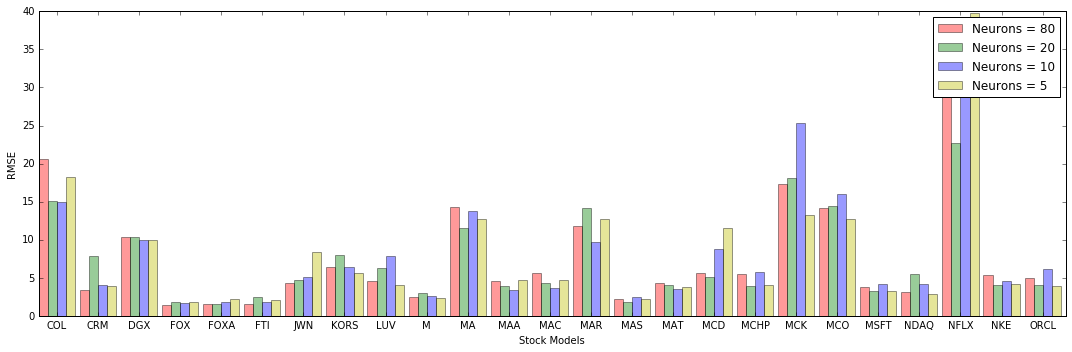

In [17]:
i = 0
bar_width = 1.0/len(n_neurons) - 0.03
opacity = 0.4
colors = ['r','g','b','y', 'm']

pyplot.figure(figsize=(15,5))
for n in n_neurons:
    predicted_dfs, summary_df = results[n]
    #print('Number of neurons', n)
    #print(summary_df.sort_values('Stock Model')[['Stock Model', 'rsme']])
    objects = summary_df.sort_values('Stock Model')['Stock Model']
    values = summary_df.sort_values('Stock Model')['rsme'].tolist()
    y_pos = np.arange(len(values))
    '''
    print(y_pos, objects,values)
    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('rsme')
    plt.title('Stock''s rsme')
    
    plt.show()
    ''' 
    plt.bar(y_pos + bar_width*i, values, bar_width,
                 alpha=opacity,
                 color=colors[i], #np.random.rand(len(n_neurons),),
                 label='Neurons = ' + str(n))
    plt.xlabel('Stock Models')
    plt.ylabel('RMSE')
    i += 1

plt.xticks(y_pos + len(n_neurons)*bar_width / 2, objects)
plt.legend()
plt.tight_layout()
plt.show()

              80         20         10         5 
count  25.000000  25.000000  25.000000  25.000000
mean    7.653866   7.280162   8.033496   7.798943
std     7.250539   5.675826   7.634151   8.090236
min     1.483080   1.559328   1.702785   1.820809
25%     3.353479   3.916069   3.550905   3.229513
50%     4.962629   4.639351   5.036048   4.169328
75%    10.334868  10.349037   9.671501  11.599826
max    32.073695  22.770387  33.163715  39.776090


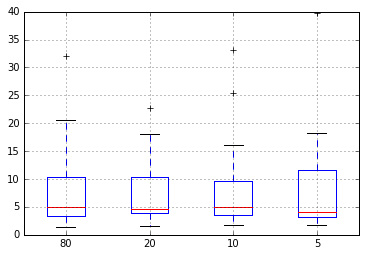

In [19]:
'''
Box plot the results
'''
df = DataFrame()
for n in n_neurons:
    predicted_dfs, summary_df = results[n]
    df[n] = summary_df.sort_values('Stock Model')['rsme'].tolist()
print(df.describe())   
df.boxplot()
plt.show()

### This shows that the median is lowest with n_neurons = 20, so we will use this value for training

   Stock Model       rsme  Day 0 predicted gain  Day 0 actual gain  \
0          COL  15.028261             -0.010258           0.022653   
1          CRM   7.887350             -0.021431          -0.016191   
2          DGX  10.349037              0.029862           0.039793   
3          FOX   1.866453              0.058061           0.034815   
4         FOXA   1.559328              0.048910           0.040352   
5          FTI   2.440112              0.031405          -0.145171   
6          JWN   4.639351              0.000002           0.154909   
7         KORS   7.980852              0.023821          -0.012476   
8          LUV   6.302329             -0.015052           0.074187   
9            M   2.984087              0.010038           0.021735   
10          MA  11.495470              0.008637           0.026913   
11         MAA   3.916069             -0.009452           0.052568   
12         MAC   4.361611             -0.016742          -0.010417   
13         MAR  14.1

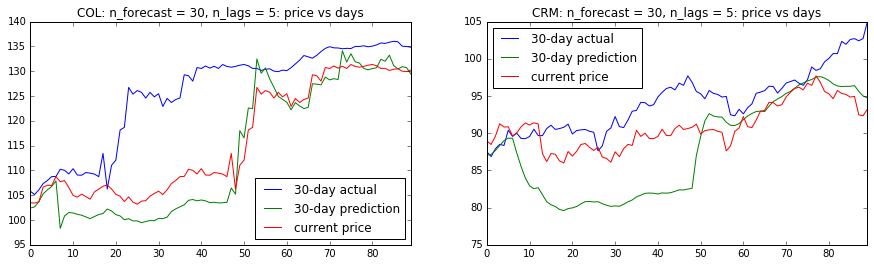

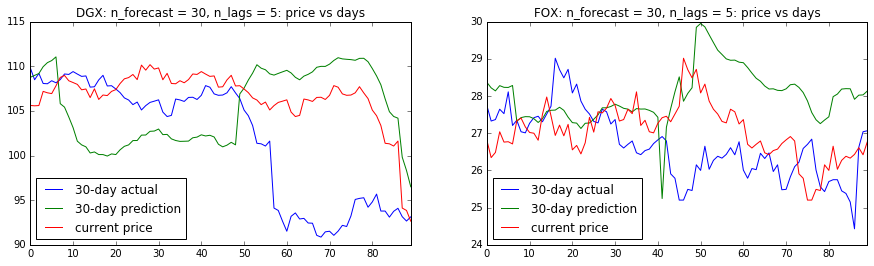

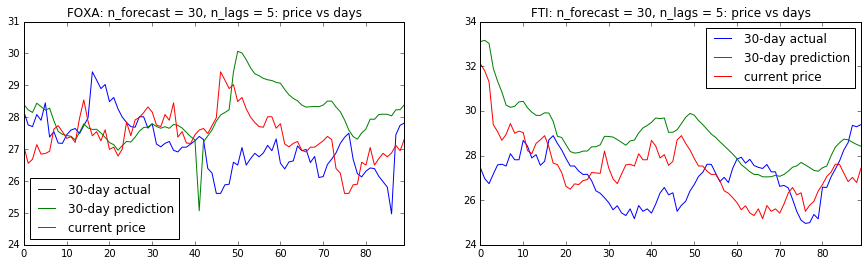

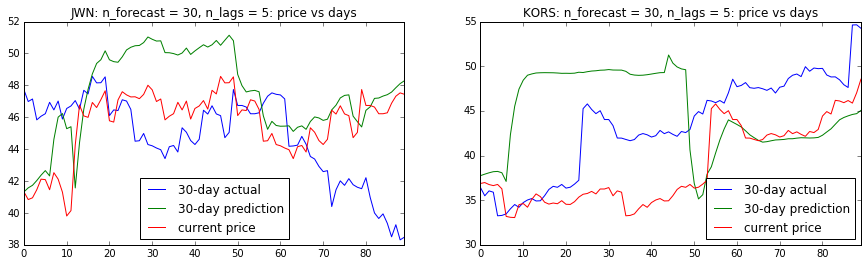

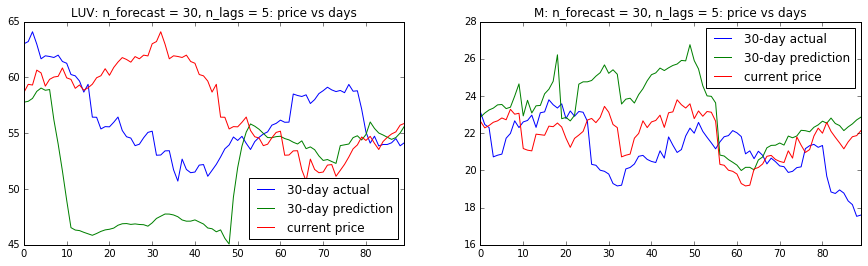

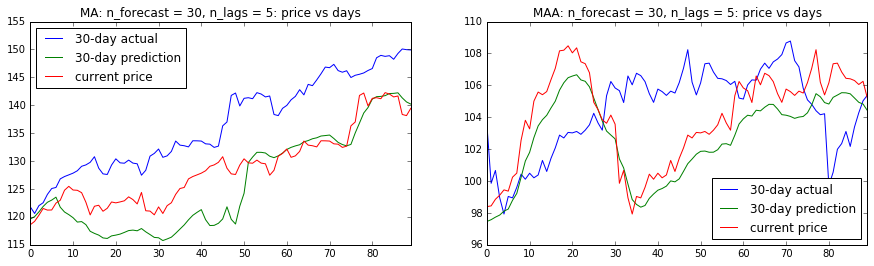

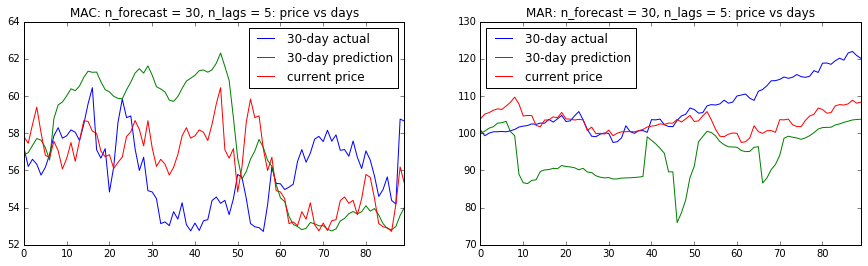

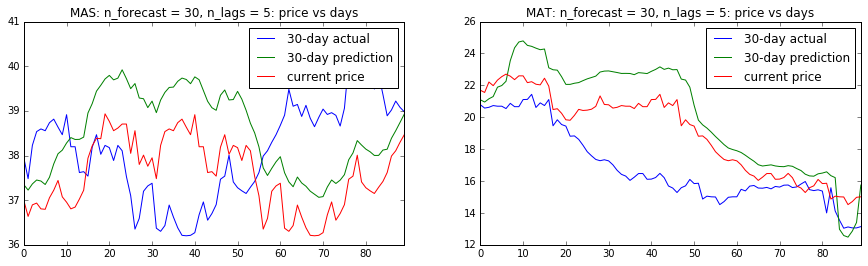

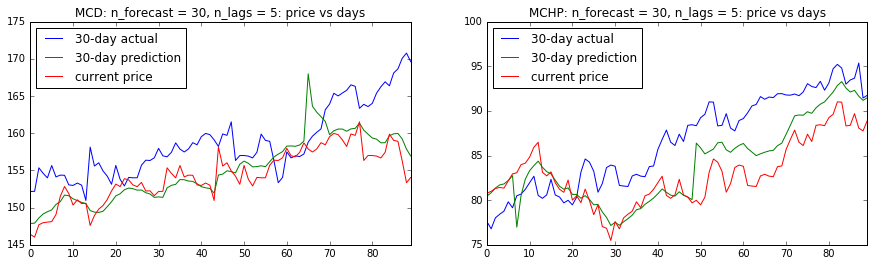

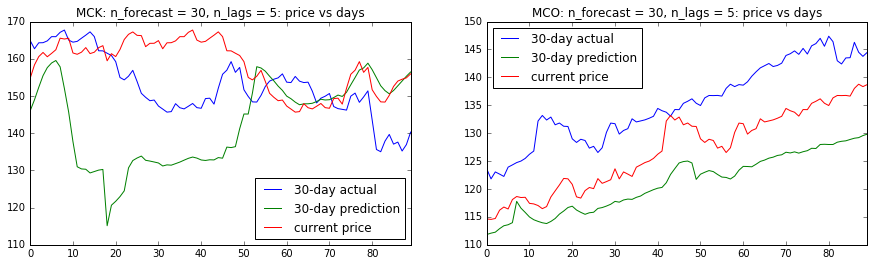

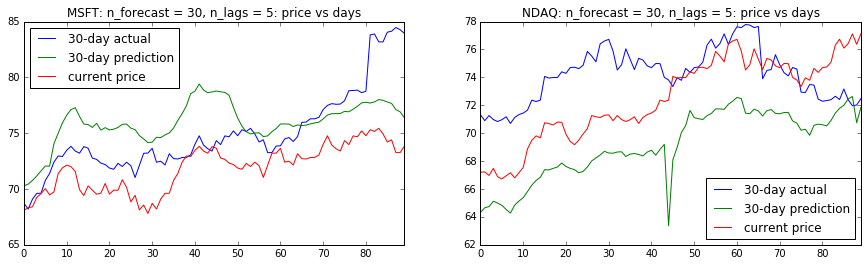

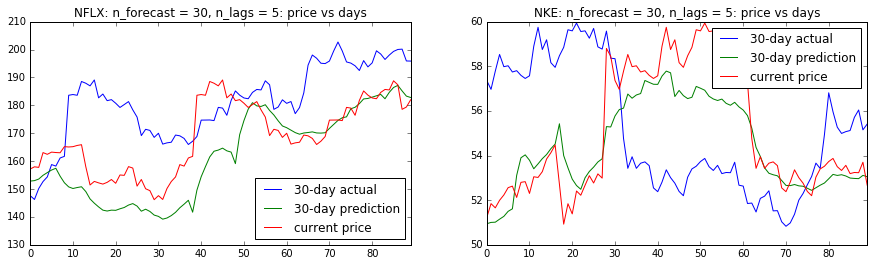

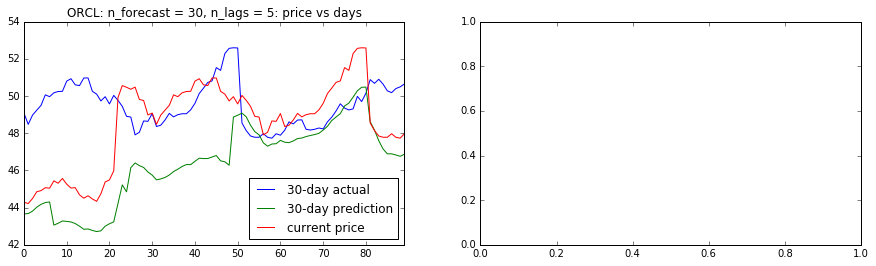

In [16]:
predicted_dfs, summary_df = results[20]
print summary_df.sort_values('Stock Model')
plot_data(summary_df, predicted_dfs)

## Observation

Comparing the 3 results together, the 3rd setting yields better accuracy

In [67]:
#np.abs(rmse_df5['Avg predicted gain'] - rmse_df5['Avg actual gain'])

In [68]:
#np.abs(rmse_df3['Avg predicted gain'] - rmse_df3['Avg actual gain'])

In [69]:
#np.abs(rmse_df2['Avg predicted gain'] - rmse_df2['Avg actual gain'])

In [70]:
#np.abs(rmse_df['Avg predicted gain'] - rmse_df['Avg actual gain'])

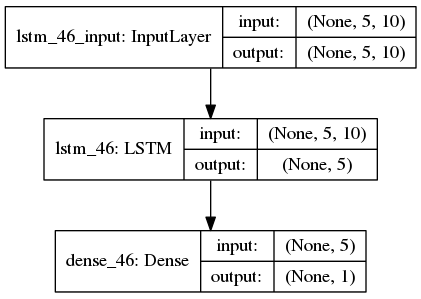

In [71]:
from keras.utils import plot_model
from keras.models import load_model
from IPython.display import Image

model_fname = '../models/sp500_test_30/MSFT.h5'
png_fname = 'MSFT.png'
plot_model(model = load_model(model_fname), to_file=png_fname, show_shapes=True, show_layer_names=True)
Image(png_fname)
